# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

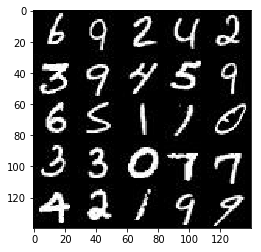

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

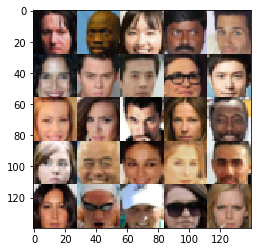

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0-rc2
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input_images = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels),name='input_real_images')
    z_data = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    alpha=0.001
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.001
    
    
    if is_train==False:
        reuse=True
    else:
        reuse=False
    
    
    with tf.variable_scope('generator',reuse= reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 512, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x512 now
        
        
        x4 = tf.layers.conv2d_transpose(x3, 1024, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x1024 now
        
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    

    samples, losses = [], []
   
    print_every=10
    show_every=100
    
    print(data_shape)
    all_data_size,image_width,image_height,out_channel= data_shape
    train_input_real, train_input_z,train_learning_rate = model_inputs(image_width,image_height,out_channel, z_dim)
    train_d_loss, train_g_loss = model_loss(train_input_real, train_input_z,out_channel)
    train_d_opt, train_g_opt = model_opt(train_d_loss, train_g_loss, train_learning_rate, beta1)
    
    if all_data_size % batch_size==0:
        all_steps = all_data_size//batch_size
    else:
        all_steps=all_data_size//batch_size+1
    
    #saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(train_d_opt, feed_dict={train_input_real: batch_images, train_input_z: batch_z,train_learning_rate:learning_rate})
                _ = sess.run(train_g_opt, feed_dict={train_input_z: batch_z, train_input_real: batch_images,train_learning_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = train_d_loss.eval({train_input_z: batch_z, train_input_real: batch_images})
                    train_loss_g = train_g_loss.eval({train_input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Steps {}/{}...".format(steps,all_steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(train_input_z, out_channel, is_train=False),
                                   feed_dict={train_input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess,25, train_input_z, out_channel, data_image_mode)
                    

        #saver.save(sess, './checkpoints/generator.ckpt')
        print("Train procedure is completed!")


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Steps 10/938... Discriminator Loss: 0.2321... Generator Loss: 2.0610
Epoch 1/2... Steps 20/938... Discriminator Loss: 0.4707... Generator Loss: 1.6423
Epoch 1/2... Steps 30/938... Discriminator Loss: 0.2157... Generator Loss: 2.7047
Epoch 1/2... Steps 40/938... Discriminator Loss: 0.4768... Generator Loss: 1.4533
Epoch 1/2... Steps 50/938... Discriminator Loss: 0.6002... Generator Loss: 1.2786
Epoch 1/2... Steps 60/938... Discriminator Loss: 0.1241... Generator Loss: 2.9073
Epoch 1/2... Steps 70/938... Discriminator Loss: 0.0825... Generator Loss: 3.2003
Epoch 1/2... Steps 80/938... Discriminator Loss: 0.0843... Generator Loss: 3.2453
Epoch 1/2... Steps 90/938... Discriminator Loss: 0.7586... Generator Loss: 1.7581
Epoch 1/2... Steps 100/938... Discriminator Loss: 0.1088... Generator Loss: 3.1253


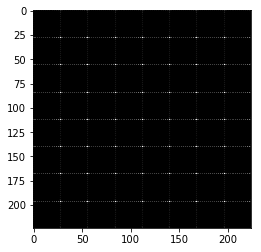

Epoch 1/2... Steps 110/938... Discriminator Loss: 0.0374... Generator Loss: 4.2108
Epoch 1/2... Steps 120/938... Discriminator Loss: 0.0391... Generator Loss: 4.4559
Epoch 1/2... Steps 130/938... Discriminator Loss: 0.0406... Generator Loss: 3.8901
Epoch 1/2... Steps 140/938... Discriminator Loss: 0.0458... Generator Loss: 3.4450
Epoch 1/2... Steps 150/938... Discriminator Loss: 0.4366... Generator Loss: 2.6082
Epoch 1/2... Steps 160/938... Discriminator Loss: 0.2975... Generator Loss: 2.1113
Epoch 1/2... Steps 170/938... Discriminator Loss: 0.0609... Generator Loss: 3.7816
Epoch 1/2... Steps 180/938... Discriminator Loss: 0.2910... Generator Loss: 2.6438
Epoch 1/2... Steps 190/938... Discriminator Loss: 1.1389... Generator Loss: 0.8223
Epoch 1/2... Steps 200/938... Discriminator Loss: 0.8017... Generator Loss: 1.3024


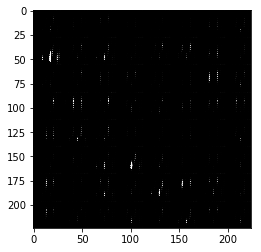

Epoch 1/2... Steps 210/938... Discriminator Loss: 0.3570... Generator Loss: 2.1222
Epoch 1/2... Steps 220/938... Discriminator Loss: 1.3012... Generator Loss: 1.3499
Epoch 1/2... Steps 230/938... Discriminator Loss: 0.6370... Generator Loss: 1.9926
Epoch 1/2... Steps 240/938... Discriminator Loss: 3.6054... Generator Loss: 0.2210
Epoch 1/2... Steps 250/938... Discriminator Loss: 1.2875... Generator Loss: 0.7616
Epoch 1/2... Steps 260/938... Discriminator Loss: 1.0997... Generator Loss: 0.7856
Epoch 1/2... Steps 270/938... Discriminator Loss: 1.2643... Generator Loss: 1.1846
Epoch 1/2... Steps 280/938... Discriminator Loss: 1.3238... Generator Loss: 0.9823
Epoch 1/2... Steps 290/938... Discriminator Loss: 0.9429... Generator Loss: 0.9225
Epoch 1/2... Steps 300/938... Discriminator Loss: 1.8775... Generator Loss: 0.5708


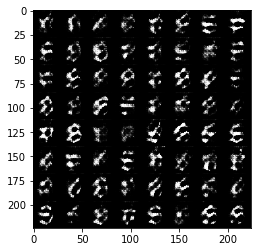

Epoch 1/2... Steps 310/938... Discriminator Loss: 1.3115... Generator Loss: 0.9438
Epoch 1/2... Steps 320/938... Discriminator Loss: 1.4630... Generator Loss: 0.6968
Epoch 1/2... Steps 330/938... Discriminator Loss: 0.9888... Generator Loss: 0.9746
Epoch 1/2... Steps 340/938... Discriminator Loss: 0.7444... Generator Loss: 1.3519
Epoch 1/2... Steps 350/938... Discriminator Loss: 1.1427... Generator Loss: 0.8783
Epoch 1/2... Steps 360/938... Discriminator Loss: 1.1852... Generator Loss: 0.9662
Epoch 1/2... Steps 370/938... Discriminator Loss: 1.4106... Generator Loss: 0.7181
Epoch 1/2... Steps 380/938... Discriminator Loss: 1.4946... Generator Loss: 0.9207
Epoch 1/2... Steps 390/938... Discriminator Loss: 1.3346... Generator Loss: 0.8464
Epoch 1/2... Steps 400/938... Discriminator Loss: 1.3766... Generator Loss: 0.6633


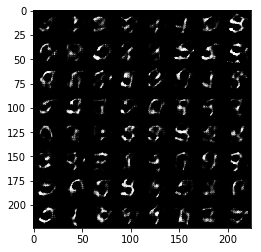

Epoch 1/2... Steps 410/938... Discriminator Loss: 1.2244... Generator Loss: 0.8931
Epoch 1/2... Steps 420/938... Discriminator Loss: 1.2988... Generator Loss: 0.7479
Epoch 1/2... Steps 430/938... Discriminator Loss: 1.4471... Generator Loss: 0.5736
Epoch 1/2... Steps 440/938... Discriminator Loss: 1.2623... Generator Loss: 0.7664
Epoch 1/2... Steps 450/938... Discriminator Loss: 1.1729... Generator Loss: 0.7323
Epoch 1/2... Steps 460/938... Discriminator Loss: 1.2821... Generator Loss: 0.8084
Epoch 1/2... Steps 470/938... Discriminator Loss: 1.3643... Generator Loss: 0.5650
Epoch 1/2... Steps 480/938... Discriminator Loss: 1.3937... Generator Loss: 0.6183
Epoch 1/2... Steps 490/938... Discriminator Loss: 1.4669... Generator Loss: 0.5476
Epoch 1/2... Steps 500/938... Discriminator Loss: 1.5426... Generator Loss: 0.6232


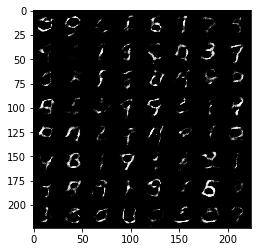

Epoch 1/2... Steps 510/938... Discriminator Loss: 1.4604... Generator Loss: 0.6674
Epoch 1/2... Steps 520/938... Discriminator Loss: 1.3444... Generator Loss: 0.8372
Epoch 1/2... Steps 530/938... Discriminator Loss: 1.2984... Generator Loss: 0.7773
Epoch 1/2... Steps 540/938... Discriminator Loss: 1.3991... Generator Loss: 0.6738
Epoch 1/2... Steps 550/938... Discriminator Loss: 1.2887... Generator Loss: 0.6506
Epoch 1/2... Steps 560/938... Discriminator Loss: 1.3548... Generator Loss: 0.6147
Epoch 1/2... Steps 570/938... Discriminator Loss: 1.5026... Generator Loss: 0.5203
Epoch 1/2... Steps 580/938... Discriminator Loss: 1.3928... Generator Loss: 0.7204
Epoch 1/2... Steps 590/938... Discriminator Loss: 1.3536... Generator Loss: 0.7922
Epoch 1/2... Steps 600/938... Discriminator Loss: 1.4119... Generator Loss: 0.5239


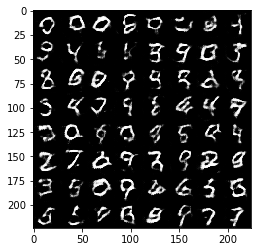

Epoch 1/2... Steps 610/938... Discriminator Loss: 1.3530... Generator Loss: 0.6581
Epoch 1/2... Steps 620/938... Discriminator Loss: 1.3455... Generator Loss: 0.7914
Epoch 1/2... Steps 630/938... Discriminator Loss: 1.3622... Generator Loss: 0.6374
Epoch 1/2... Steps 640/938... Discriminator Loss: 1.4024... Generator Loss: 0.6468
Epoch 1/2... Steps 650/938... Discriminator Loss: 1.2826... Generator Loss: 0.6865
Epoch 1/2... Steps 660/938... Discriminator Loss: 1.3683... Generator Loss: 0.6698
Epoch 1/2... Steps 670/938... Discriminator Loss: 1.3976... Generator Loss: 0.7555
Epoch 1/2... Steps 680/938... Discriminator Loss: 1.3225... Generator Loss: 0.6940
Epoch 1/2... Steps 690/938... Discriminator Loss: 1.3311... Generator Loss: 0.8140
Epoch 1/2... Steps 700/938... Discriminator Loss: 1.3420... Generator Loss: 0.6853


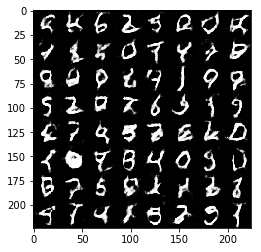

Epoch 1/2... Steps 710/938... Discriminator Loss: 1.3183... Generator Loss: 0.5859
Epoch 1/2... Steps 720/938... Discriminator Loss: 1.2896... Generator Loss: 0.7271
Epoch 1/2... Steps 730/938... Discriminator Loss: 1.3493... Generator Loss: 0.7361
Epoch 1/2... Steps 740/938... Discriminator Loss: 1.3055... Generator Loss: 0.5722
Epoch 1/2... Steps 750/938... Discriminator Loss: 1.3533... Generator Loss: 0.6828
Epoch 1/2... Steps 760/938... Discriminator Loss: 1.2736... Generator Loss: 0.8192
Epoch 1/2... Steps 770/938... Discriminator Loss: 1.3288... Generator Loss: 0.6285
Epoch 1/2... Steps 780/938... Discriminator Loss: 1.3583... Generator Loss: 0.6057
Epoch 1/2... Steps 790/938... Discriminator Loss: 1.3793... Generator Loss: 0.5834
Epoch 1/2... Steps 800/938... Discriminator Loss: 1.3030... Generator Loss: 0.7779


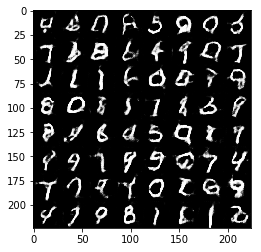

Epoch 1/2... Steps 810/938... Discriminator Loss: 1.3297... Generator Loss: 0.6091
Epoch 1/2... Steps 820/938... Discriminator Loss: 1.3383... Generator Loss: 0.5753
Epoch 1/2... Steps 830/938... Discriminator Loss: 1.2689... Generator Loss: 0.8239
Epoch 1/2... Steps 840/938... Discriminator Loss: 1.2378... Generator Loss: 0.9510
Epoch 1/2... Steps 850/938... Discriminator Loss: 1.2122... Generator Loss: 0.7216
Epoch 1/2... Steps 860/938... Discriminator Loss: 1.2461... Generator Loss: 0.8202
Epoch 1/2... Steps 870/938... Discriminator Loss: 1.4269... Generator Loss: 0.5185
Epoch 1/2... Steps 880/938... Discriminator Loss: 1.2048... Generator Loss: 0.7351
Epoch 1/2... Steps 890/938... Discriminator Loss: 1.3004... Generator Loss: 0.9459
Epoch 1/2... Steps 900/938... Discriminator Loss: 1.3013... Generator Loss: 0.7227


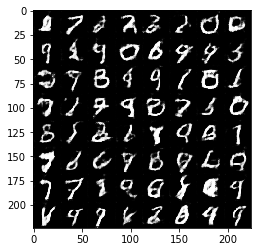

Epoch 1/2... Steps 910/938... Discriminator Loss: 1.2889... Generator Loss: 0.6547
Epoch 1/2... Steps 920/938... Discriminator Loss: 1.2758... Generator Loss: 0.7447
Epoch 1/2... Steps 930/938... Discriminator Loss: 1.3068... Generator Loss: 0.7258
Epoch 2/2... Steps 10/938... Discriminator Loss: 1.3483... Generator Loss: 0.6677
Epoch 2/2... Steps 20/938... Discriminator Loss: 1.2859... Generator Loss: 0.6254
Epoch 2/2... Steps 30/938... Discriminator Loss: 1.3190... Generator Loss: 0.7376
Epoch 2/2... Steps 40/938... Discriminator Loss: 1.2814... Generator Loss: 0.7803
Epoch 2/2... Steps 50/938... Discriminator Loss: 1.3262... Generator Loss: 0.8228
Epoch 2/2... Steps 60/938... Discriminator Loss: 1.2760... Generator Loss: 0.8144
Epoch 2/2... Steps 70/938... Discriminator Loss: 1.2778... Generator Loss: 0.7373
Epoch 2/2... Steps 80/938... Discriminator Loss: 1.3004... Generator Loss: 0.5934
Epoch 2/2... Steps 90/938... Discriminator Loss: 1.2657... Generator Loss: 0.6790
Epoch 2/2... 

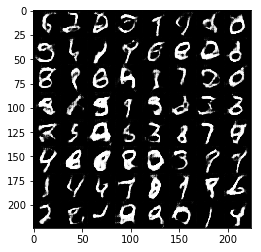

Epoch 2/2... Steps 110/938... Discriminator Loss: 1.2896... Generator Loss: 0.6713
Epoch 2/2... Steps 120/938... Discriminator Loss: 1.3711... Generator Loss: 0.6154
Epoch 2/2... Steps 130/938... Discriminator Loss: 1.2969... Generator Loss: 0.7910
Epoch 2/2... Steps 140/938... Discriminator Loss: 1.2832... Generator Loss: 0.6592
Epoch 2/2... Steps 150/938... Discriminator Loss: 1.3011... Generator Loss: 0.6111
Epoch 2/2... Steps 160/938... Discriminator Loss: 1.3740... Generator Loss: 0.8235
Epoch 2/2... Steps 170/938... Discriminator Loss: 1.3259... Generator Loss: 0.6517
Epoch 2/2... Steps 180/938... Discriminator Loss: 1.2405... Generator Loss: 0.6557
Epoch 2/2... Steps 190/938... Discriminator Loss: 1.4568... Generator Loss: 0.4669
Epoch 2/2... Steps 200/938... Discriminator Loss: 1.3327... Generator Loss: 0.9247


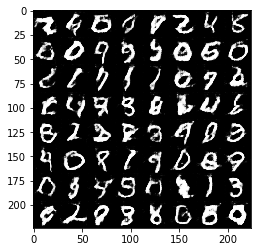

Epoch 2/2... Steps 210/938... Discriminator Loss: 1.3614... Generator Loss: 0.8760
Epoch 2/2... Steps 220/938... Discriminator Loss: 1.3560... Generator Loss: 1.0632
Epoch 2/2... Steps 230/938... Discriminator Loss: 1.3355... Generator Loss: 0.5711
Epoch 2/2... Steps 240/938... Discriminator Loss: 1.2822... Generator Loss: 0.7481
Epoch 2/2... Steps 250/938... Discriminator Loss: 1.3589... Generator Loss: 0.5535
Epoch 2/2... Steps 260/938... Discriminator Loss: 1.4221... Generator Loss: 0.4607
Epoch 2/2... Steps 270/938... Discriminator Loss: 1.1783... Generator Loss: 0.7321
Epoch 2/2... Steps 280/938... Discriminator Loss: 1.3816... Generator Loss: 0.5600
Epoch 2/2... Steps 290/938... Discriminator Loss: 1.2239... Generator Loss: 0.7279
Epoch 2/2... Steps 300/938... Discriminator Loss: 1.2991... Generator Loss: 0.7454


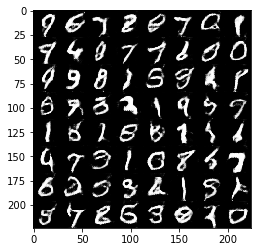

Epoch 2/2... Steps 310/938... Discriminator Loss: 1.3373... Generator Loss: 0.6514
Epoch 2/2... Steps 320/938... Discriminator Loss: 1.3518... Generator Loss: 0.5121
Epoch 2/2... Steps 330/938... Discriminator Loss: 1.3199... Generator Loss: 0.6718
Epoch 2/2... Steps 340/938... Discriminator Loss: 1.2070... Generator Loss: 0.8767
Epoch 2/2... Steps 350/938... Discriminator Loss: 1.3488... Generator Loss: 0.4930
Epoch 2/2... Steps 360/938... Discriminator Loss: 1.3172... Generator Loss: 0.7614
Epoch 2/2... Steps 370/938... Discriminator Loss: 1.2385... Generator Loss: 0.7448
Epoch 2/2... Steps 380/938... Discriminator Loss: 1.3113... Generator Loss: 0.6092
Epoch 2/2... Steps 390/938... Discriminator Loss: 1.3583... Generator Loss: 0.5291
Epoch 2/2... Steps 400/938... Discriminator Loss: 1.2857... Generator Loss: 0.8851


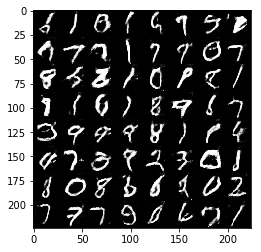

Epoch 2/2... Steps 410/938... Discriminator Loss: 1.2534... Generator Loss: 0.6577
Epoch 2/2... Steps 420/938... Discriminator Loss: 1.2264... Generator Loss: 1.0049
Epoch 2/2... Steps 430/938... Discriminator Loss: 1.3203... Generator Loss: 0.5968
Epoch 2/2... Steps 440/938... Discriminator Loss: 1.2444... Generator Loss: 0.7090
Epoch 2/2... Steps 450/938... Discriminator Loss: 1.3434... Generator Loss: 0.7670
Epoch 2/2... Steps 460/938... Discriminator Loss: 1.2386... Generator Loss: 0.9952
Epoch 2/2... Steps 470/938... Discriminator Loss: 1.3481... Generator Loss: 0.7794
Epoch 2/2... Steps 480/938... Discriminator Loss: 1.3160... Generator Loss: 0.9200
Epoch 2/2... Steps 490/938... Discriminator Loss: 1.3065... Generator Loss: 0.5722
Epoch 2/2... Steps 500/938... Discriminator Loss: 1.2583... Generator Loss: 0.7247


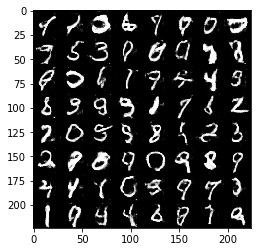

Epoch 2/2... Steps 510/938... Discriminator Loss: 1.3326... Generator Loss: 0.6902
Epoch 2/2... Steps 520/938... Discriminator Loss: 1.2248... Generator Loss: 0.7673
Epoch 2/2... Steps 530/938... Discriminator Loss: 1.3880... Generator Loss: 0.4828
Epoch 2/2... Steps 540/938... Discriminator Loss: 1.2544... Generator Loss: 0.6817
Epoch 2/2... Steps 550/938... Discriminator Loss: 1.1920... Generator Loss: 0.7219
Epoch 2/2... Steps 560/938... Discriminator Loss: 1.3548... Generator Loss: 0.8202
Epoch 2/2... Steps 570/938... Discriminator Loss: 1.3251... Generator Loss: 0.6908
Epoch 2/2... Steps 580/938... Discriminator Loss: 1.2051... Generator Loss: 0.8042
Epoch 2/2... Steps 590/938... Discriminator Loss: 1.1730... Generator Loss: 0.9981
Epoch 2/2... Steps 600/938... Discriminator Loss: 1.2009... Generator Loss: 0.7265


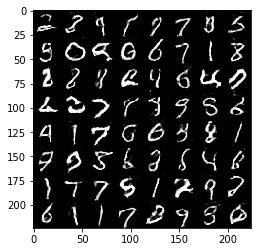

Epoch 2/2... Steps 610/938... Discriminator Loss: 1.2381... Generator Loss: 0.7285
Epoch 2/2... Steps 620/938... Discriminator Loss: 1.2317... Generator Loss: 0.7115
Epoch 2/2... Steps 630/938... Discriminator Loss: 1.2585... Generator Loss: 0.7993
Epoch 2/2... Steps 640/938... Discriminator Loss: 1.2073... Generator Loss: 0.7891
Epoch 2/2... Steps 650/938... Discriminator Loss: 1.2579... Generator Loss: 0.9163
Epoch 2/2... Steps 660/938... Discriminator Loss: 1.5033... Generator Loss: 0.7776
Epoch 2/2... Steps 670/938... Discriminator Loss: 1.3690... Generator Loss: 0.6983
Epoch 2/2... Steps 680/938... Discriminator Loss: 1.3053... Generator Loss: 0.6985
Epoch 2/2... Steps 690/938... Discriminator Loss: 1.3864... Generator Loss: 0.5627
Epoch 2/2... Steps 700/938... Discriminator Loss: 1.2991... Generator Loss: 0.6886


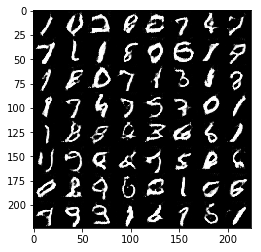

Epoch 2/2... Steps 710/938... Discriminator Loss: 1.3960... Generator Loss: 0.4738
Epoch 2/2... Steps 720/938... Discriminator Loss: 1.2645... Generator Loss: 0.8859
Epoch 2/2... Steps 730/938... Discriminator Loss: 1.3259... Generator Loss: 0.7860
Epoch 2/2... Steps 740/938... Discriminator Loss: 1.1711... Generator Loss: 0.8056
Epoch 2/2... Steps 750/938... Discriminator Loss: 1.3420... Generator Loss: 0.6320
Epoch 2/2... Steps 760/938... Discriminator Loss: 1.1455... Generator Loss: 0.7469
Epoch 2/2... Steps 770/938... Discriminator Loss: 1.4339... Generator Loss: 0.5693
Epoch 2/2... Steps 780/938... Discriminator Loss: 1.4736... Generator Loss: 0.6190
Epoch 2/2... Steps 790/938... Discriminator Loss: 1.3215... Generator Loss: 0.6560
Epoch 2/2... Steps 800/938... Discriminator Loss: 1.3553... Generator Loss: 0.5171


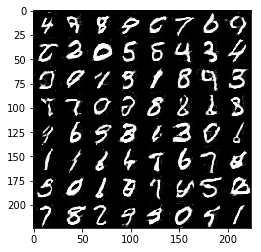

Epoch 2/2... Steps 810/938... Discriminator Loss: 1.3392... Generator Loss: 0.7544
Epoch 2/2... Steps 820/938... Discriminator Loss: 1.3287... Generator Loss: 0.5033
Epoch 2/2... Steps 830/938... Discriminator Loss: 1.1360... Generator Loss: 0.6988
Epoch 2/2... Steps 840/938... Discriminator Loss: 1.2390... Generator Loss: 0.9318
Epoch 2/2... Steps 850/938... Discriminator Loss: 1.3252... Generator Loss: 0.5422
Epoch 2/2... Steps 860/938... Discriminator Loss: 1.3218... Generator Loss: 0.8442
Epoch 2/2... Steps 870/938... Discriminator Loss: 1.2908... Generator Loss: 0.7023
Epoch 2/2... Steps 880/938... Discriminator Loss: 1.2900... Generator Loss: 0.7567
Epoch 2/2... Steps 890/938... Discriminator Loss: 1.3452... Generator Loss: 0.4847
Epoch 2/2... Steps 900/938... Discriminator Loss: 1.4525... Generator Loss: 0.4432


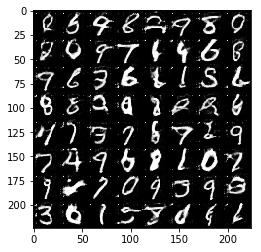

Epoch 2/2... Steps 910/938... Discriminator Loss: 1.3686... Generator Loss: 0.8000
Epoch 2/2... Steps 920/938... Discriminator Loss: 1.3696... Generator Loss: 0.8486
Epoch 2/2... Steps 930/938... Discriminator Loss: 1.4020... Generator Loss: 0.6040
Train procedure is completed!


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Steps 10/6332... Discriminator Loss: 0.8460... Generator Loss: 1.1544
Epoch 1/1... Steps 20/6332... Discriminator Loss: 1.4029... Generator Loss: 0.4993
Epoch 1/1... Steps 30/6332... Discriminator Loss: 0.6967... Generator Loss: 1.0506
Epoch 1/1... Steps 40/6332... Discriminator Loss: 0.9931... Generator Loss: 0.8947
Epoch 1/1... Steps 50/6332... Discriminator Loss: 0.6213... Generator Loss: 1.7895
Epoch 1/1... Steps 60/6332... Discriminator Loss: 1.1547... Generator Loss: 0.8125
Epoch 1/1... Steps 70/6332... Discriminator Loss: 1.0160... Generator Loss: 1.1112
Epoch 1/1... Steps 80/6332... Discriminator Loss: 0.8965... Generator Loss: 1.0172
Epoch 1/1... Steps 90/6332... Discriminator Loss: 0.7395... Generator Loss: 1.2591
Epoch 1/1... Steps 100/6332... Discriminator Loss: 0.9392... Generator Loss: 1.7740


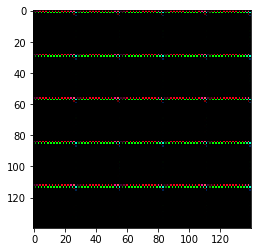

Epoch 1/1... Steps 110/6332... Discriminator Loss: 1.3461... Generator Loss: 0.4821
Epoch 1/1... Steps 120/6332... Discriminator Loss: 0.7314... Generator Loss: 1.2770
Epoch 1/1... Steps 130/6332... Discriminator Loss: 0.9980... Generator Loss: 0.6771
Epoch 1/1... Steps 140/6332... Discriminator Loss: 1.0453... Generator Loss: 0.8698
Epoch 1/1... Steps 150/6332... Discriminator Loss: 0.9231... Generator Loss: 1.1174
Epoch 1/1... Steps 160/6332... Discriminator Loss: 1.9047... Generator Loss: 0.7113
Epoch 1/1... Steps 170/6332... Discriminator Loss: 1.1903... Generator Loss: 0.5933
Epoch 1/1... Steps 180/6332... Discriminator Loss: 0.8709... Generator Loss: 1.4254
Epoch 1/1... Steps 190/6332... Discriminator Loss: 1.3361... Generator Loss: 1.4661
Epoch 1/1... Steps 200/6332... Discriminator Loss: 0.9044... Generator Loss: 1.2939


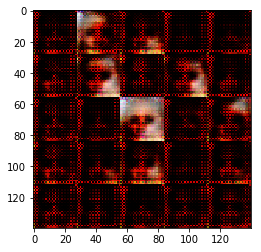

Epoch 1/1... Steps 210/6332... Discriminator Loss: 0.8485... Generator Loss: 1.0489
Epoch 1/1... Steps 220/6332... Discriminator Loss: 0.5545... Generator Loss: 1.8618
Epoch 1/1... Steps 230/6332... Discriminator Loss: 1.0672... Generator Loss: 0.8302
Epoch 1/1... Steps 240/6332... Discriminator Loss: 1.3153... Generator Loss: 0.5073
Epoch 1/1... Steps 250/6332... Discriminator Loss: 1.4787... Generator Loss: 1.0424
Epoch 1/1... Steps 260/6332... Discriminator Loss: 1.3624... Generator Loss: 0.7080
Epoch 1/1... Steps 270/6332... Discriminator Loss: 1.3105... Generator Loss: 0.6427
Epoch 1/1... Steps 280/6332... Discriminator Loss: 0.9291... Generator Loss: 1.2136
Epoch 1/1... Steps 290/6332... Discriminator Loss: 1.0534... Generator Loss: 1.0296
Epoch 1/1... Steps 300/6332... Discriminator Loss: 1.1523... Generator Loss: 1.1608


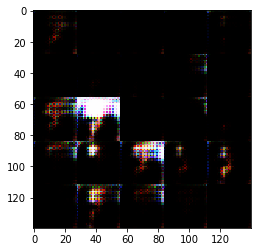

Epoch 1/1... Steps 310/6332... Discriminator Loss: 1.2909... Generator Loss: 1.5078
Epoch 1/1... Steps 320/6332... Discriminator Loss: 1.4608... Generator Loss: 0.6683
Epoch 1/1... Steps 330/6332... Discriminator Loss: 1.4411... Generator Loss: 0.4946
Epoch 1/1... Steps 340/6332... Discriminator Loss: 0.8139... Generator Loss: 1.5707
Epoch 1/1... Steps 350/6332... Discriminator Loss: 0.9760... Generator Loss: 1.6205
Epoch 1/1... Steps 360/6332... Discriminator Loss: 1.6172... Generator Loss: 0.3625
Epoch 1/1... Steps 370/6332... Discriminator Loss: 1.3297... Generator Loss: 0.6055
Epoch 1/1... Steps 380/6332... Discriminator Loss: 1.9390... Generator Loss: 0.4942
Epoch 1/1... Steps 390/6332... Discriminator Loss: 0.7065... Generator Loss: 1.4285
Epoch 1/1... Steps 400/6332... Discriminator Loss: 1.4659... Generator Loss: 1.4382


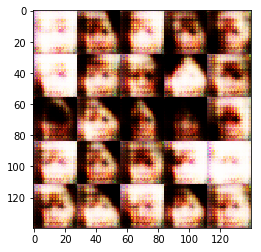

Epoch 1/1... Steps 410/6332... Discriminator Loss: 1.0773... Generator Loss: 1.3408
Epoch 1/1... Steps 420/6332... Discriminator Loss: 1.1032... Generator Loss: 0.6085
Epoch 1/1... Steps 430/6332... Discriminator Loss: 1.4395... Generator Loss: 1.2565
Epoch 1/1... Steps 440/6332... Discriminator Loss: 1.0962... Generator Loss: 0.8389
Epoch 1/1... Steps 450/6332... Discriminator Loss: 1.3993... Generator Loss: 0.4073
Epoch 1/1... Steps 460/6332... Discriminator Loss: 0.9383... Generator Loss: 0.8727
Epoch 1/1... Steps 470/6332... Discriminator Loss: 1.3306... Generator Loss: 0.8075
Epoch 1/1... Steps 480/6332... Discriminator Loss: 1.7569... Generator Loss: 0.2677
Epoch 1/1... Steps 490/6332... Discriminator Loss: 0.9660... Generator Loss: 1.5664
Epoch 1/1... Steps 500/6332... Discriminator Loss: 1.1056... Generator Loss: 1.1031


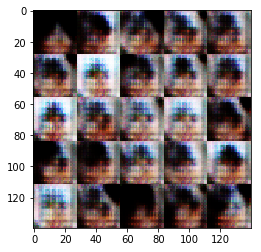

Epoch 1/1... Steps 510/6332... Discriminator Loss: 1.7147... Generator Loss: 0.5698
Epoch 1/1... Steps 520/6332... Discriminator Loss: 1.2106... Generator Loss: 0.9915
Epoch 1/1... Steps 530/6332... Discriminator Loss: 1.5228... Generator Loss: 0.6138
Epoch 1/1... Steps 540/6332... Discriminator Loss: 1.4861... Generator Loss: 0.6547
Epoch 1/1... Steps 550/6332... Discriminator Loss: 1.6542... Generator Loss: 0.5795
Epoch 1/1... Steps 560/6332... Discriminator Loss: 1.0156... Generator Loss: 1.2652
Epoch 1/1... Steps 570/6332... Discriminator Loss: 1.2615... Generator Loss: 0.7272
Epoch 1/1... Steps 580/6332... Discriminator Loss: 1.4480... Generator Loss: 0.7243
Epoch 1/1... Steps 590/6332... Discriminator Loss: 2.2173... Generator Loss: 0.3017
Epoch 1/1... Steps 600/6332... Discriminator Loss: 0.9000... Generator Loss: 1.2841


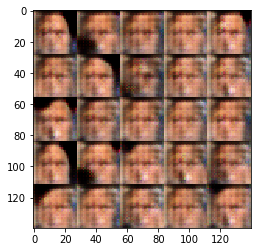

Epoch 1/1... Steps 610/6332... Discriminator Loss: 1.5266... Generator Loss: 0.6606
Epoch 1/1... Steps 620/6332... Discriminator Loss: 1.7585... Generator Loss: 0.4616
Epoch 1/1... Steps 630/6332... Discriminator Loss: 0.9833... Generator Loss: 0.6669
Epoch 1/1... Steps 640/6332... Discriminator Loss: 1.1986... Generator Loss: 0.8564
Epoch 1/1... Steps 650/6332... Discriminator Loss: 1.3766... Generator Loss: 0.9045
Epoch 1/1... Steps 660/6332... Discriminator Loss: 1.4569... Generator Loss: 0.6810
Epoch 1/1... Steps 670/6332... Discriminator Loss: 1.6086... Generator Loss: 1.1392
Epoch 1/1... Steps 680/6332... Discriminator Loss: 1.1348... Generator Loss: 0.9575
Epoch 1/1... Steps 690/6332... Discriminator Loss: 1.7280... Generator Loss: 0.6988
Epoch 1/1... Steps 700/6332... Discriminator Loss: 1.4259... Generator Loss: 0.5632


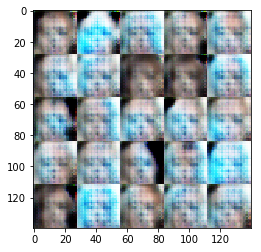

Epoch 1/1... Steps 710/6332... Discriminator Loss: 1.0104... Generator Loss: 0.8622
Epoch 1/1... Steps 720/6332... Discriminator Loss: 1.7107... Generator Loss: 0.5476
Epoch 1/1... Steps 730/6332... Discriminator Loss: 1.7440... Generator Loss: 0.4144
Epoch 1/1... Steps 740/6332... Discriminator Loss: 0.9418... Generator Loss: 0.9272
Epoch 1/1... Steps 750/6332... Discriminator Loss: 0.7594... Generator Loss: 1.9974
Epoch 1/1... Steps 760/6332... Discriminator Loss: 1.2518... Generator Loss: 0.7984
Epoch 1/1... Steps 770/6332... Discriminator Loss: 1.0930... Generator Loss: 1.1969
Epoch 1/1... Steps 780/6332... Discriminator Loss: 1.5186... Generator Loss: 0.6292
Epoch 1/1... Steps 790/6332... Discriminator Loss: 1.4855... Generator Loss: 0.6877
Epoch 1/1... Steps 800/6332... Discriminator Loss: 1.6591... Generator Loss: 0.6465


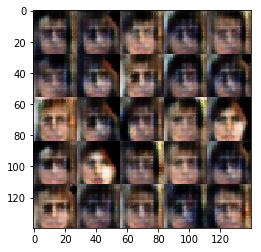

Epoch 1/1... Steps 810/6332... Discriminator Loss: 1.9755... Generator Loss: 0.2877
Epoch 1/1... Steps 820/6332... Discriminator Loss: 1.0880... Generator Loss: 0.8437
Epoch 1/1... Steps 830/6332... Discriminator Loss: 1.3193... Generator Loss: 0.9130
Epoch 1/1... Steps 840/6332... Discriminator Loss: 1.4148... Generator Loss: 0.7511
Epoch 1/1... Steps 850/6332... Discriminator Loss: 1.4296... Generator Loss: 0.8277
Epoch 1/1... Steps 860/6332... Discriminator Loss: 1.3262... Generator Loss: 0.8626
Epoch 1/1... Steps 870/6332... Discriminator Loss: 1.7086... Generator Loss: 0.3423
Epoch 1/1... Steps 880/6332... Discriminator Loss: 1.4802... Generator Loss: 0.7058
Epoch 1/1... Steps 890/6332... Discriminator Loss: 1.6348... Generator Loss: 0.8274
Epoch 1/1... Steps 900/6332... Discriminator Loss: 1.2875... Generator Loss: 0.8637


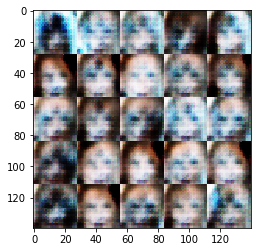

Epoch 1/1... Steps 910/6332... Discriminator Loss: 0.9276... Generator Loss: 1.4487
Epoch 1/1... Steps 920/6332... Discriminator Loss: 1.3108... Generator Loss: 0.8851
Epoch 1/1... Steps 930/6332... Discriminator Loss: 1.4204... Generator Loss: 0.8033
Epoch 1/1... Steps 940/6332... Discriminator Loss: 1.3091... Generator Loss: 0.6281
Epoch 1/1... Steps 950/6332... Discriminator Loss: 0.5465... Generator Loss: 3.3905
Epoch 1/1... Steps 960/6332... Discriminator Loss: 1.3833... Generator Loss: 0.6172
Epoch 1/1... Steps 970/6332... Discriminator Loss: 1.2350... Generator Loss: 0.5518
Epoch 1/1... Steps 980/6332... Discriminator Loss: 1.2318... Generator Loss: 0.9567
Epoch 1/1... Steps 990/6332... Discriminator Loss: 0.8679... Generator Loss: 1.0589
Epoch 1/1... Steps 1000/6332... Discriminator Loss: 1.3689... Generator Loss: 0.7636


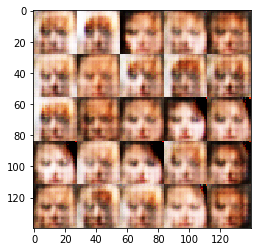

Epoch 1/1... Steps 1010/6332... Discriminator Loss: 0.9231... Generator Loss: 1.3428
Epoch 1/1... Steps 1020/6332... Discriminator Loss: 1.4825... Generator Loss: 0.4141
Epoch 1/1... Steps 1030/6332... Discriminator Loss: 1.3496... Generator Loss: 0.7495
Epoch 1/1... Steps 1040/6332... Discriminator Loss: 1.4705... Generator Loss: 0.6955
Epoch 1/1... Steps 1050/6332... Discriminator Loss: 1.3398... Generator Loss: 0.8027
Epoch 1/1... Steps 1060/6332... Discriminator Loss: 1.2995... Generator Loss: 0.9285
Epoch 1/1... Steps 1070/6332... Discriminator Loss: 1.5442... Generator Loss: 0.7529
Epoch 1/1... Steps 1080/6332... Discriminator Loss: 0.8774... Generator Loss: 2.3889
Epoch 1/1... Steps 1090/6332... Discriminator Loss: 1.2672... Generator Loss: 0.8172
Epoch 1/1... Steps 1100/6332... Discriminator Loss: 1.3553... Generator Loss: 0.5810


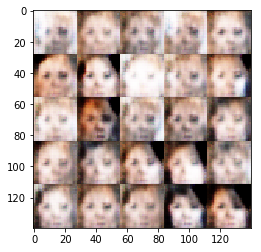

Epoch 1/1... Steps 1110/6332... Discriminator Loss: 0.6769... Generator Loss: 1.1266
Epoch 1/1... Steps 1120/6332... Discriminator Loss: 1.4321... Generator Loss: 0.8890
Epoch 1/1... Steps 1130/6332... Discriminator Loss: 1.2938... Generator Loss: 1.1115
Epoch 1/1... Steps 1140/6332... Discriminator Loss: 1.3038... Generator Loss: 1.0387
Epoch 1/1... Steps 1150/6332... Discriminator Loss: 1.2195... Generator Loss: 0.6356
Epoch 1/1... Steps 1160/6332... Discriminator Loss: 1.4852... Generator Loss: 2.4332
Epoch 1/1... Steps 1170/6332... Discriminator Loss: 1.7389... Generator Loss: 0.7583
Epoch 1/1... Steps 1180/6332... Discriminator Loss: 1.3888... Generator Loss: 0.6235
Epoch 1/1... Steps 1190/6332... Discriminator Loss: 1.4508... Generator Loss: 0.9208
Epoch 1/1... Steps 1200/6332... Discriminator Loss: 1.2289... Generator Loss: 0.7894


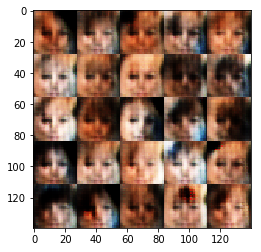

Epoch 1/1... Steps 1210/6332... Discriminator Loss: 1.2888... Generator Loss: 0.7358
Epoch 1/1... Steps 1220/6332... Discriminator Loss: 1.5224... Generator Loss: 0.8078
Epoch 1/1... Steps 1230/6332... Discriminator Loss: 1.3494... Generator Loss: 0.4582
Epoch 1/1... Steps 1240/6332... Discriminator Loss: 1.9843... Generator Loss: 0.2568
Epoch 1/1... Steps 1250/6332... Discriminator Loss: 1.2622... Generator Loss: 0.7486
Epoch 1/1... Steps 1260/6332... Discriminator Loss: 1.0364... Generator Loss: 0.9366
Epoch 1/1... Steps 1270/6332... Discriminator Loss: 1.3008... Generator Loss: 0.5027
Epoch 1/1... Steps 1280/6332... Discriminator Loss: 1.6096... Generator Loss: 0.7624
Epoch 1/1... Steps 1290/6332... Discriminator Loss: 1.5991... Generator Loss: 0.4889
Epoch 1/1... Steps 1300/6332... Discriminator Loss: 1.0581... Generator Loss: 0.8114


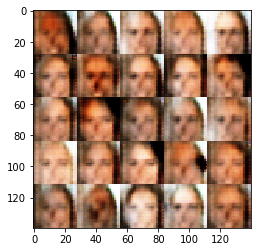

Epoch 1/1... Steps 1310/6332... Discriminator Loss: 1.3421... Generator Loss: 0.7688
Epoch 1/1... Steps 1320/6332... Discriminator Loss: 1.1822... Generator Loss: 0.8078
Epoch 1/1... Steps 1330/6332... Discriminator Loss: 1.1347... Generator Loss: 1.0038
Epoch 1/1... Steps 1340/6332... Discriminator Loss: 1.4524... Generator Loss: 1.4258
Epoch 1/1... Steps 1350/6332... Discriminator Loss: 1.1046... Generator Loss: 0.8184
Epoch 1/1... Steps 1360/6332... Discriminator Loss: 0.7403... Generator Loss: 1.3433
Epoch 1/1... Steps 1370/6332... Discriminator Loss: 1.3479... Generator Loss: 0.5214
Epoch 1/1... Steps 1380/6332... Discriminator Loss: 1.4221... Generator Loss: 0.4312
Epoch 1/1... Steps 1390/6332... Discriminator Loss: 1.3323... Generator Loss: 1.1759
Epoch 1/1... Steps 1400/6332... Discriminator Loss: 1.3713... Generator Loss: 0.8629


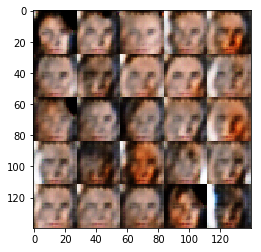

Epoch 1/1... Steps 1410/6332... Discriminator Loss: 1.0917... Generator Loss: 1.0944
Epoch 1/1... Steps 1420/6332... Discriminator Loss: 1.4601... Generator Loss: 0.6455
Epoch 1/1... Steps 1430/6332... Discriminator Loss: 0.5863... Generator Loss: 2.0866
Epoch 1/1... Steps 1440/6332... Discriminator Loss: 0.6628... Generator Loss: 1.5806
Epoch 1/1... Steps 1450/6332... Discriminator Loss: 1.0492... Generator Loss: 0.8389
Epoch 1/1... Steps 1460/6332... Discriminator Loss: 0.9316... Generator Loss: 0.9618
Epoch 1/1... Steps 1470/6332... Discriminator Loss: 1.2836... Generator Loss: 0.6976
Epoch 1/1... Steps 1480/6332... Discriminator Loss: 1.3987... Generator Loss: 0.6144
Epoch 1/1... Steps 1490/6332... Discriminator Loss: 1.2613... Generator Loss: 0.7085
Epoch 1/1... Steps 1500/6332... Discriminator Loss: 1.2492... Generator Loss: 0.8152


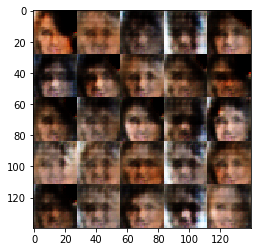

Epoch 1/1... Steps 1510/6332... Discriminator Loss: 1.0804... Generator Loss: 0.9584
Epoch 1/1... Steps 1520/6332... Discriminator Loss: 0.9541... Generator Loss: 0.9731
Epoch 1/1... Steps 1530/6332... Discriminator Loss: 0.8385... Generator Loss: 1.5281
Epoch 1/1... Steps 1540/6332... Discriminator Loss: 1.3268... Generator Loss: 0.8984
Epoch 1/1... Steps 1550/6332... Discriminator Loss: 1.1815... Generator Loss: 1.1706
Epoch 1/1... Steps 1560/6332... Discriminator Loss: 1.1251... Generator Loss: 1.0158
Epoch 1/1... Steps 1570/6332... Discriminator Loss: 1.3142... Generator Loss: 1.2127
Epoch 1/1... Steps 1580/6332... Discriminator Loss: 0.9118... Generator Loss: 1.4076
Epoch 1/1... Steps 1590/6332... Discriminator Loss: 1.2624... Generator Loss: 0.7035
Epoch 1/1... Steps 1600/6332... Discriminator Loss: 1.7524... Generator Loss: 0.2792


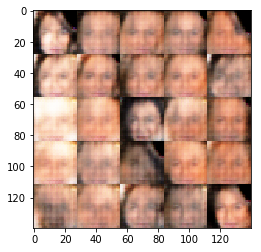

Epoch 1/1... Steps 1610/6332... Discriminator Loss: 1.3059... Generator Loss: 1.0022
Epoch 1/1... Steps 1620/6332... Discriminator Loss: 1.1905... Generator Loss: 0.8122
Epoch 1/1... Steps 1630/6332... Discriminator Loss: 1.0332... Generator Loss: 0.9694
Epoch 1/1... Steps 1640/6332... Discriminator Loss: 0.8253... Generator Loss: 2.4303
Epoch 1/1... Steps 1650/6332... Discriminator Loss: 1.1780... Generator Loss: 1.6377
Epoch 1/1... Steps 1660/6332... Discriminator Loss: 1.5063... Generator Loss: 0.6962
Epoch 1/1... Steps 1670/6332... Discriminator Loss: 1.5498... Generator Loss: 0.6860
Epoch 1/1... Steps 1680/6332... Discriminator Loss: 1.4343... Generator Loss: 0.4791
Epoch 1/1... Steps 1690/6332... Discriminator Loss: 0.3834... Generator Loss: 1.6368
Epoch 1/1... Steps 1700/6332... Discriminator Loss: 1.2740... Generator Loss: 0.7073


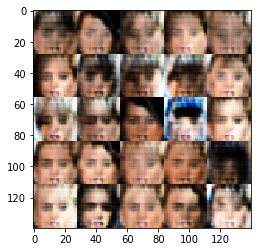

Epoch 1/1... Steps 1710/6332... Discriminator Loss: 1.5532... Generator Loss: 0.4512
Epoch 1/1... Steps 1720/6332... Discriminator Loss: 1.5437... Generator Loss: 0.6488
Epoch 1/1... Steps 1730/6332... Discriminator Loss: 0.9020... Generator Loss: 0.9183
Epoch 1/1... Steps 1740/6332... Discriminator Loss: 1.4359... Generator Loss: 0.4043
Epoch 1/1... Steps 1750/6332... Discriminator Loss: 2.1461... Generator Loss: 0.1633
Epoch 1/1... Steps 1760/6332... Discriminator Loss: 1.1505... Generator Loss: 0.7341
Epoch 1/1... Steps 1770/6332... Discriminator Loss: 1.0968... Generator Loss: 1.8170
Epoch 1/1... Steps 1780/6332... Discriminator Loss: 1.3841... Generator Loss: 0.6323
Epoch 1/1... Steps 1790/6332... Discriminator Loss: 0.5425... Generator Loss: 1.4637
Epoch 1/1... Steps 1800/6332... Discriminator Loss: 0.9842... Generator Loss: 1.2524


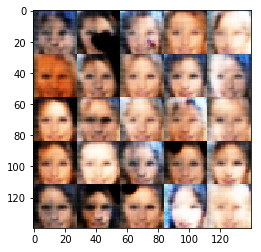

Epoch 1/1... Steps 1810/6332... Discriminator Loss: 1.7593... Generator Loss: 0.3310
Epoch 1/1... Steps 1820/6332... Discriminator Loss: 1.1051... Generator Loss: 0.9188
Epoch 1/1... Steps 1830/6332... Discriminator Loss: 0.7380... Generator Loss: 1.5065
Epoch 1/1... Steps 1840/6332... Discriminator Loss: 1.7338... Generator Loss: 0.4932
Epoch 1/1... Steps 1850/6332... Discriminator Loss: 0.9460... Generator Loss: 0.8734
Epoch 1/1... Steps 1860/6332... Discriminator Loss: 1.2569... Generator Loss: 1.1272
Epoch 1/1... Steps 1870/6332... Discriminator Loss: 1.4567... Generator Loss: 0.4206
Epoch 1/1... Steps 1880/6332... Discriminator Loss: 1.1384... Generator Loss: 0.6128
Epoch 1/1... Steps 1890/6332... Discriminator Loss: 1.3409... Generator Loss: 0.9011
Epoch 1/1... Steps 1900/6332... Discriminator Loss: 1.1998... Generator Loss: 0.7900


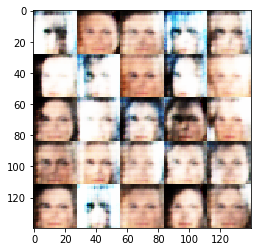

Epoch 1/1... Steps 1910/6332... Discriminator Loss: 1.4448... Generator Loss: 0.4720
Epoch 1/1... Steps 1920/6332... Discriminator Loss: 1.2444... Generator Loss: 0.9539
Epoch 1/1... Steps 1930/6332... Discriminator Loss: 1.4269... Generator Loss: 0.4427
Epoch 1/1... Steps 1940/6332... Discriminator Loss: 1.0741... Generator Loss: 1.3107
Epoch 1/1... Steps 1950/6332... Discriminator Loss: 1.1218... Generator Loss: 1.2568
Epoch 1/1... Steps 1960/6332... Discriminator Loss: 0.5799... Generator Loss: 1.0238
Epoch 1/1... Steps 1970/6332... Discriminator Loss: 1.2545... Generator Loss: 0.6838
Epoch 1/1... Steps 1980/6332... Discriminator Loss: 0.6902... Generator Loss: 1.4575
Epoch 1/1... Steps 1990/6332... Discriminator Loss: 0.3432... Generator Loss: 2.3790
Epoch 1/1... Steps 2000/6332... Discriminator Loss: 1.4050... Generator Loss: 0.4910


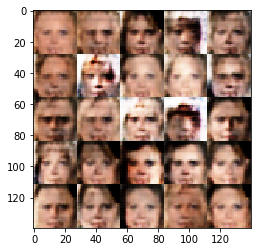

Epoch 1/1... Steps 2010/6332... Discriminator Loss: 0.8839... Generator Loss: 1.3509
Epoch 1/1... Steps 2020/6332... Discriminator Loss: 1.3990... Generator Loss: 1.1932
Epoch 1/1... Steps 2030/6332... Discriminator Loss: 1.4605... Generator Loss: 0.8825
Epoch 1/1... Steps 2040/6332... Discriminator Loss: 0.6128... Generator Loss: 3.0398
Epoch 1/1... Steps 2050/6332... Discriminator Loss: 1.2745... Generator Loss: 0.8172
Epoch 1/1... Steps 2060/6332... Discriminator Loss: 1.2561... Generator Loss: 0.7438
Epoch 1/1... Steps 2070/6332... Discriminator Loss: 1.1715... Generator Loss: 0.7950
Epoch 1/1... Steps 2080/6332... Discriminator Loss: 1.0792... Generator Loss: 1.0117
Epoch 1/1... Steps 2090/6332... Discriminator Loss: 1.6143... Generator Loss: 0.3158
Epoch 1/1... Steps 2100/6332... Discriminator Loss: 0.5595... Generator Loss: 2.8184


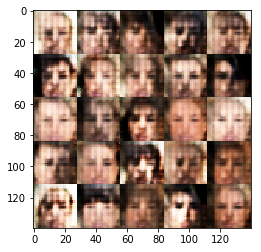

Epoch 1/1... Steps 2110/6332... Discriminator Loss: 0.8760... Generator Loss: 1.3823
Epoch 1/1... Steps 2120/6332... Discriminator Loss: 1.3162... Generator Loss: 0.5828
Epoch 1/1... Steps 2130/6332... Discriminator Loss: 1.2431... Generator Loss: 0.8183
Epoch 1/1... Steps 2140/6332... Discriminator Loss: 1.0571... Generator Loss: 0.9647
Epoch 1/1... Steps 2150/6332... Discriminator Loss: 1.2776... Generator Loss: 0.6598
Epoch 1/1... Steps 2160/6332... Discriminator Loss: 1.2443... Generator Loss: 1.2351
Epoch 1/1... Steps 2170/6332... Discriminator Loss: 0.9099... Generator Loss: 1.6238
Epoch 1/1... Steps 2180/6332... Discriminator Loss: 0.9310... Generator Loss: 0.9277
Epoch 1/1... Steps 2190/6332... Discriminator Loss: 1.4315... Generator Loss: 0.7687
Epoch 1/1... Steps 2200/6332... Discriminator Loss: 1.2908... Generator Loss: 1.1583


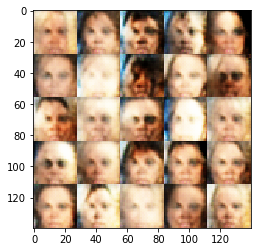

Epoch 1/1... Steps 2210/6332... Discriminator Loss: 1.0008... Generator Loss: 1.4636
Epoch 1/1... Steps 2220/6332... Discriminator Loss: 1.4121... Generator Loss: 0.4973
Epoch 1/1... Steps 2230/6332... Discriminator Loss: 1.2046... Generator Loss: 0.6400
Epoch 1/1... Steps 2240/6332... Discriminator Loss: 1.2831... Generator Loss: 0.7171
Epoch 1/1... Steps 2250/6332... Discriminator Loss: 1.3188... Generator Loss: 0.7660
Epoch 1/1... Steps 2260/6332... Discriminator Loss: 1.2838... Generator Loss: 0.6569
Epoch 1/1... Steps 2270/6332... Discriminator Loss: 1.1284... Generator Loss: 1.1777
Epoch 1/1... Steps 2280/6332... Discriminator Loss: 1.8104... Generator Loss: 0.2560
Epoch 1/1... Steps 2290/6332... Discriminator Loss: 0.8133... Generator Loss: 1.5750
Epoch 1/1... Steps 2300/6332... Discriminator Loss: 1.1261... Generator Loss: 0.8615


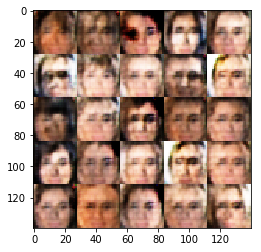

Epoch 1/1... Steps 2310/6332... Discriminator Loss: 1.6442... Generator Loss: 0.3687
Epoch 1/1... Steps 2320/6332... Discriminator Loss: 1.0945... Generator Loss: 0.6733
Epoch 1/1... Steps 2330/6332... Discriminator Loss: 1.7611... Generator Loss: 0.2974
Epoch 1/1... Steps 2340/6332... Discriminator Loss: 0.6576... Generator Loss: 1.1244
Epoch 1/1... Steps 2350/6332... Discriminator Loss: 1.9670... Generator Loss: 0.2393
Epoch 1/1... Steps 2360/6332... Discriminator Loss: 1.4481... Generator Loss: 0.6084
Epoch 1/1... Steps 2370/6332... Discriminator Loss: 1.2793... Generator Loss: 0.6829
Epoch 1/1... Steps 2380/6332... Discriminator Loss: 1.2508... Generator Loss: 0.7360
Epoch 1/1... Steps 2390/6332... Discriminator Loss: 1.7617... Generator Loss: 0.2852
Epoch 1/1... Steps 2400/6332... Discriminator Loss: 0.8397... Generator Loss: 1.4818


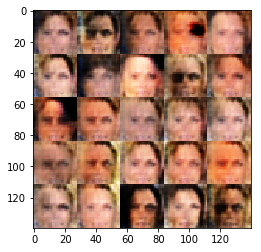

Epoch 1/1... Steps 2410/6332... Discriminator Loss: 0.8875... Generator Loss: 1.3077
Epoch 1/1... Steps 2420/6332... Discriminator Loss: 0.9860... Generator Loss: 0.8556
Epoch 1/1... Steps 2430/6332... Discriminator Loss: 1.4397... Generator Loss: 0.5880
Epoch 1/1... Steps 2440/6332... Discriminator Loss: 0.8213... Generator Loss: 1.4324
Epoch 1/1... Steps 2450/6332... Discriminator Loss: 1.2445... Generator Loss: 0.9262
Epoch 1/1... Steps 2460/6332... Discriminator Loss: 1.3186... Generator Loss: 0.7579
Epoch 1/1... Steps 2470/6332... Discriminator Loss: 1.1810... Generator Loss: 0.7009
Epoch 1/1... Steps 2480/6332... Discriminator Loss: 1.0657... Generator Loss: 1.2795
Epoch 1/1... Steps 2490/6332... Discriminator Loss: 1.3505... Generator Loss: 0.7119
Epoch 1/1... Steps 2500/6332... Discriminator Loss: 1.3337... Generator Loss: 0.8981


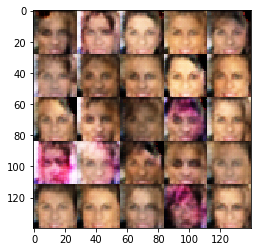

Epoch 1/1... Steps 2510/6332... Discriminator Loss: 0.9649... Generator Loss: 0.7599
Epoch 1/1... Steps 2520/6332... Discriminator Loss: 1.1642... Generator Loss: 0.6342
Epoch 1/1... Steps 2530/6332... Discriminator Loss: 1.6021... Generator Loss: 0.5272
Epoch 1/1... Steps 2540/6332... Discriminator Loss: 1.0587... Generator Loss: 1.0049
Epoch 1/1... Steps 2550/6332... Discriminator Loss: 1.2271... Generator Loss: 0.8354
Epoch 1/1... Steps 2560/6332... Discriminator Loss: 0.7959... Generator Loss: 1.3017
Epoch 1/1... Steps 2570/6332... Discriminator Loss: 1.1025... Generator Loss: 1.0764
Epoch 1/1... Steps 2580/6332... Discriminator Loss: 1.3557... Generator Loss: 0.6388
Epoch 1/1... Steps 2590/6332... Discriminator Loss: 0.8695... Generator Loss: 2.0017
Epoch 1/1... Steps 2600/6332... Discriminator Loss: 1.3383... Generator Loss: 0.7900


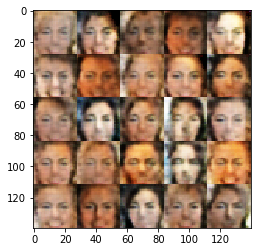

Epoch 1/1... Steps 2610/6332... Discriminator Loss: 1.3764... Generator Loss: 0.6822
Epoch 1/1... Steps 2620/6332... Discriminator Loss: 1.0871... Generator Loss: 1.8187
Epoch 1/1... Steps 2630/6332... Discriminator Loss: 1.3058... Generator Loss: 0.7039
Epoch 1/1... Steps 2640/6332... Discriminator Loss: 1.1633... Generator Loss: 0.7545
Epoch 1/1... Steps 2650/6332... Discriminator Loss: 1.4698... Generator Loss: 0.3959
Epoch 1/1... Steps 2660/6332... Discriminator Loss: 1.3195... Generator Loss: 0.9148
Epoch 1/1... Steps 2670/6332... Discriminator Loss: 0.7737... Generator Loss: 1.0682
Epoch 1/1... Steps 2680/6332... Discriminator Loss: 1.3261... Generator Loss: 0.8666
Epoch 1/1... Steps 2690/6332... Discriminator Loss: 1.4878... Generator Loss: 0.7051
Epoch 1/1... Steps 2700/6332... Discriminator Loss: 1.1186... Generator Loss: 0.6166


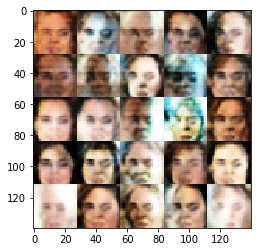

Epoch 1/1... Steps 2710/6332... Discriminator Loss: 1.3624... Generator Loss: 0.3954
Epoch 1/1... Steps 2720/6332... Discriminator Loss: 1.3412... Generator Loss: 0.4924
Epoch 1/1... Steps 2730/6332... Discriminator Loss: 0.9954... Generator Loss: 1.9038
Epoch 1/1... Steps 2740/6332... Discriminator Loss: 1.1818... Generator Loss: 0.7681
Epoch 1/1... Steps 2750/6332... Discriminator Loss: 1.1086... Generator Loss: 0.7408
Epoch 1/1... Steps 2760/6332... Discriminator Loss: 1.3036... Generator Loss: 0.5392
Epoch 1/1... Steps 2770/6332... Discriminator Loss: 1.4360... Generator Loss: 0.6273
Epoch 1/1... Steps 2780/6332... Discriminator Loss: 1.3640... Generator Loss: 0.5729
Epoch 1/1... Steps 2790/6332... Discriminator Loss: 1.3320... Generator Loss: 0.4438
Epoch 1/1... Steps 2800/6332... Discriminator Loss: 1.7718... Generator Loss: 1.0376


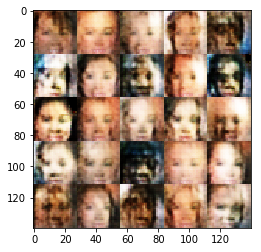

Epoch 1/1... Steps 2810/6332... Discriminator Loss: 1.2464... Generator Loss: 0.8567
Epoch 1/1... Steps 2820/6332... Discriminator Loss: 1.1891... Generator Loss: 0.8608
Epoch 1/1... Steps 2830/6332... Discriminator Loss: 1.0492... Generator Loss: 2.4381
Epoch 1/1... Steps 2840/6332... Discriminator Loss: 1.1561... Generator Loss: 0.8714
Epoch 1/1... Steps 2850/6332... Discriminator Loss: 1.5120... Generator Loss: 0.5593
Epoch 1/1... Steps 2860/6332... Discriminator Loss: 1.4100... Generator Loss: 0.8713
Epoch 1/1... Steps 2870/6332... Discriminator Loss: 1.2265... Generator Loss: 0.8145
Epoch 1/1... Steps 2880/6332... Discriminator Loss: 1.5465... Generator Loss: 0.9196
Epoch 1/1... Steps 2890/6332... Discriminator Loss: 1.0356... Generator Loss: 1.8151
Epoch 1/1... Steps 2900/6332... Discriminator Loss: 1.1043... Generator Loss: 0.7540


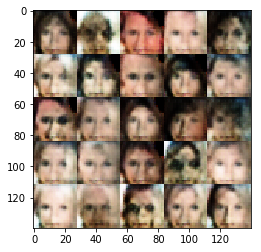

Epoch 1/1... Steps 2910/6332... Discriminator Loss: 1.5016... Generator Loss: 0.6835
Epoch 1/1... Steps 2920/6332... Discriminator Loss: 1.4537... Generator Loss: 0.5666
Epoch 1/1... Steps 2930/6332... Discriminator Loss: 0.8501... Generator Loss: 1.3854
Epoch 1/1... Steps 2940/6332... Discriminator Loss: 1.2322... Generator Loss: 0.9356
Epoch 1/1... Steps 2950/6332... Discriminator Loss: 1.1190... Generator Loss: 0.7999
Epoch 1/1... Steps 2960/6332... Discriminator Loss: 0.7819... Generator Loss: 1.1644
Epoch 1/1... Steps 2970/6332... Discriminator Loss: 1.0118... Generator Loss: 0.7584
Epoch 1/1... Steps 2980/6332... Discriminator Loss: 1.6076... Generator Loss: 0.5657
Epoch 1/1... Steps 2990/6332... Discriminator Loss: 1.6768... Generator Loss: 0.4294
Epoch 1/1... Steps 3000/6332... Discriminator Loss: 0.9158... Generator Loss: 1.4015


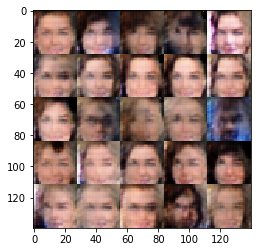

Epoch 1/1... Steps 3010/6332... Discriminator Loss: 0.8201... Generator Loss: 1.4708
Epoch 1/1... Steps 3020/6332... Discriminator Loss: 1.1012... Generator Loss: 1.2139
Epoch 1/1... Steps 3030/6332... Discriminator Loss: 1.2303... Generator Loss: 0.7040
Epoch 1/1... Steps 3040/6332... Discriminator Loss: 0.9120... Generator Loss: 1.2876
Epoch 1/1... Steps 3050/6332... Discriminator Loss: 1.3907... Generator Loss: 0.6129
Epoch 1/1... Steps 3060/6332... Discriminator Loss: 1.1294... Generator Loss: 1.7877
Epoch 1/1... Steps 3070/6332... Discriminator Loss: 0.9259... Generator Loss: 1.3077
Epoch 1/1... Steps 3080/6332... Discriminator Loss: 1.1536... Generator Loss: 0.8330
Epoch 1/1... Steps 3090/6332... Discriminator Loss: 1.2867... Generator Loss: 1.0640
Epoch 1/1... Steps 3100/6332... Discriminator Loss: 1.0739... Generator Loss: 1.1028


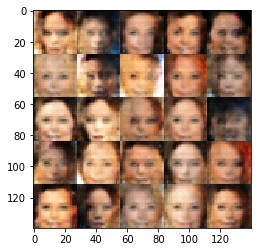

Epoch 1/1... Steps 3110/6332... Discriminator Loss: 1.3828... Generator Loss: 0.9368
Epoch 1/1... Steps 3120/6332... Discriminator Loss: 1.2843... Generator Loss: 0.6699
Epoch 1/1... Steps 3130/6332... Discriminator Loss: 1.5477... Generator Loss: 0.6212
Epoch 1/1... Steps 3140/6332... Discriminator Loss: 1.0308... Generator Loss: 0.8740
Epoch 1/1... Steps 3150/6332... Discriminator Loss: 1.2560... Generator Loss: 1.1036
Epoch 1/1... Steps 3160/6332... Discriminator Loss: 1.4092... Generator Loss: 1.0153
Epoch 1/1... Steps 3170/6332... Discriminator Loss: 0.9746... Generator Loss: 1.2047
Epoch 1/1... Steps 3180/6332... Discriminator Loss: 0.9186... Generator Loss: 1.8157
Epoch 1/1... Steps 3190/6332... Discriminator Loss: 1.7301... Generator Loss: 0.3392
Epoch 1/1... Steps 3200/6332... Discriminator Loss: 1.1715... Generator Loss: 0.7746


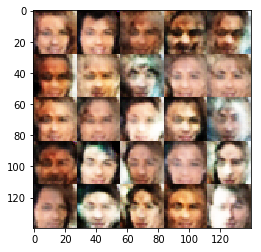

Epoch 1/1... Steps 3210/6332... Discriminator Loss: 1.4387... Generator Loss: 0.4957
Epoch 1/1... Steps 3220/6332... Discriminator Loss: 1.1170... Generator Loss: 0.6226
Epoch 1/1... Steps 3230/6332... Discriminator Loss: 1.1723... Generator Loss: 0.8466
Epoch 1/1... Steps 3240/6332... Discriminator Loss: 1.2542... Generator Loss: 0.5774
Epoch 1/1... Steps 3250/6332... Discriminator Loss: 1.3280... Generator Loss: 0.7233
Epoch 1/1... Steps 3260/6332... Discriminator Loss: 1.0848... Generator Loss: 0.9001
Epoch 1/1... Steps 3270/6332... Discriminator Loss: 1.4657... Generator Loss: 0.6910
Epoch 1/1... Steps 3280/6332... Discriminator Loss: 1.1210... Generator Loss: 1.2460
Epoch 1/1... Steps 3290/6332... Discriminator Loss: 0.9808... Generator Loss: 1.0311
Epoch 1/1... Steps 3300/6332... Discriminator Loss: 1.2292... Generator Loss: 0.8430


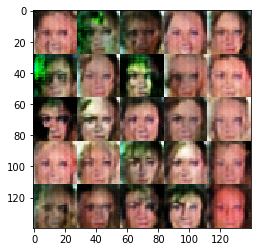

Epoch 1/1... Steps 3310/6332... Discriminator Loss: 1.1175... Generator Loss: 0.8160
Epoch 1/1... Steps 3320/6332... Discriminator Loss: 1.8090... Generator Loss: 0.2752
Epoch 1/1... Steps 3330/6332... Discriminator Loss: 0.9983... Generator Loss: 0.9918
Epoch 1/1... Steps 3340/6332... Discriminator Loss: 0.7239... Generator Loss: 1.0602
Epoch 1/1... Steps 3350/6332... Discriminator Loss: 1.1230... Generator Loss: 0.7876
Epoch 1/1... Steps 3360/6332... Discriminator Loss: 1.6929... Generator Loss: 0.5067
Epoch 1/1... Steps 3370/6332... Discriminator Loss: 1.4752... Generator Loss: 0.6292
Epoch 1/1... Steps 3380/6332... Discriminator Loss: 0.9696... Generator Loss: 1.1311
Epoch 1/1... Steps 3390/6332... Discriminator Loss: 1.2316... Generator Loss: 0.7813
Epoch 1/1... Steps 3400/6332... Discriminator Loss: 1.7452... Generator Loss: 0.4838


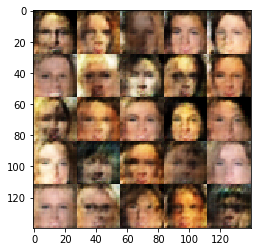

Epoch 1/1... Steps 3410/6332... Discriminator Loss: 0.8746... Generator Loss: 1.2237
Epoch 1/1... Steps 3420/6332... Discriminator Loss: 1.3705... Generator Loss: 0.6093
Epoch 1/1... Steps 3430/6332... Discriminator Loss: 1.4067... Generator Loss: 0.5572
Epoch 1/1... Steps 3440/6332... Discriminator Loss: 1.1694... Generator Loss: 0.5917
Epoch 1/1... Steps 3450/6332... Discriminator Loss: 1.2940... Generator Loss: 0.6229
Epoch 1/1... Steps 3460/6332... Discriminator Loss: 1.2773... Generator Loss: 0.9326
Epoch 1/1... Steps 3470/6332... Discriminator Loss: 0.8508... Generator Loss: 1.0202
Epoch 1/1... Steps 3480/6332... Discriminator Loss: 0.8153... Generator Loss: 1.3155
Epoch 1/1... Steps 3490/6332... Discriminator Loss: 1.2197... Generator Loss: 0.8062
Epoch 1/1... Steps 3500/6332... Discriminator Loss: 1.1650... Generator Loss: 0.8613


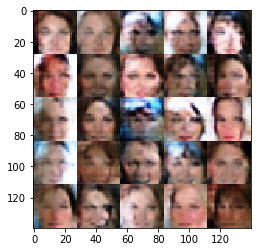

Epoch 1/1... Steps 3510/6332... Discriminator Loss: 1.2455... Generator Loss: 0.7708
Epoch 1/1... Steps 3520/6332... Discriminator Loss: 1.0842... Generator Loss: 1.1303
Epoch 1/1... Steps 3530/6332... Discriminator Loss: 1.3403... Generator Loss: 0.5589
Epoch 1/1... Steps 3540/6332... Discriminator Loss: 1.0836... Generator Loss: 0.8171
Epoch 1/1... Steps 3550/6332... Discriminator Loss: 1.2258... Generator Loss: 1.2931
Epoch 1/1... Steps 3560/6332... Discriminator Loss: 0.8966... Generator Loss: 1.1511
Epoch 1/1... Steps 3570/6332... Discriminator Loss: 0.7871... Generator Loss: 1.3632
Epoch 1/1... Steps 3580/6332... Discriminator Loss: 1.6976... Generator Loss: 1.1102
Epoch 1/1... Steps 3590/6332... Discriminator Loss: 1.0458... Generator Loss: 1.1866
Epoch 1/1... Steps 3600/6332... Discriminator Loss: 1.3372... Generator Loss: 0.7313


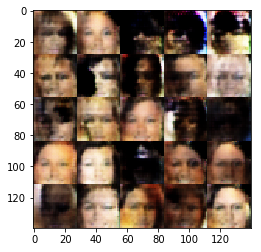

Epoch 1/1... Steps 3610/6332... Discriminator Loss: 1.5270... Generator Loss: 0.5743
Epoch 1/1... Steps 3620/6332... Discriminator Loss: 1.2043... Generator Loss: 0.7087
Epoch 1/1... Steps 3630/6332... Discriminator Loss: 1.0834... Generator Loss: 0.8368
Epoch 1/1... Steps 3640/6332... Discriminator Loss: 0.7947... Generator Loss: 1.5174
Epoch 1/1... Steps 3650/6332... Discriminator Loss: 0.9934... Generator Loss: 1.1944
Epoch 1/1... Steps 3660/6332... Discriminator Loss: 1.1322... Generator Loss: 1.0275
Epoch 1/1... Steps 3670/6332... Discriminator Loss: 1.4988... Generator Loss: 0.5576
Epoch 1/1... Steps 3680/6332... Discriminator Loss: 1.1124... Generator Loss: 0.6701
Epoch 1/1... Steps 3690/6332... Discriminator Loss: 1.3596... Generator Loss: 0.4395
Epoch 1/1... Steps 3700/6332... Discriminator Loss: 0.9199... Generator Loss: 1.4971


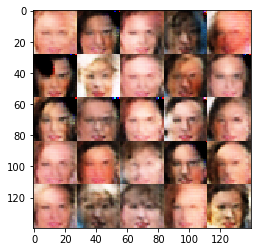

Epoch 1/1... Steps 3710/6332... Discriminator Loss: 0.6727... Generator Loss: 1.4144
Epoch 1/1... Steps 3720/6332... Discriminator Loss: 1.0492... Generator Loss: 0.9058
Epoch 1/1... Steps 3730/6332... Discriminator Loss: 1.2582... Generator Loss: 0.7547
Epoch 1/1... Steps 3740/6332... Discriminator Loss: 0.8249... Generator Loss: 0.9138
Epoch 1/1... Steps 3750/6332... Discriminator Loss: 1.0309... Generator Loss: 0.7313
Epoch 1/1... Steps 3760/6332... Discriminator Loss: 1.0532... Generator Loss: 1.0921
Epoch 1/1... Steps 3770/6332... Discriminator Loss: 1.3442... Generator Loss: 0.5742
Epoch 1/1... Steps 3780/6332... Discriminator Loss: 1.1106... Generator Loss: 0.7078
Epoch 1/1... Steps 3790/6332... Discriminator Loss: 1.1464... Generator Loss: 0.8608
Epoch 1/1... Steps 3800/6332... Discriminator Loss: 0.9942... Generator Loss: 1.1671


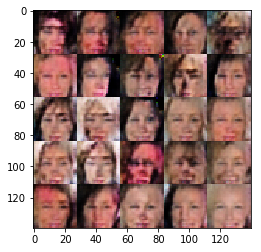

Epoch 1/1... Steps 3810/6332... Discriminator Loss: 2.3982... Generator Loss: 0.1225
Epoch 1/1... Steps 3820/6332... Discriminator Loss: 0.6121... Generator Loss: 3.1698
Epoch 1/1... Steps 3830/6332... Discriminator Loss: 0.9061... Generator Loss: 0.9078
Epoch 1/1... Steps 3840/6332... Discriminator Loss: 1.1948... Generator Loss: 0.7159
Epoch 1/1... Steps 3850/6332... Discriminator Loss: 1.1345... Generator Loss: 0.7185
Epoch 1/1... Steps 3860/6332... Discriminator Loss: 1.3446... Generator Loss: 0.5354
Epoch 1/1... Steps 3870/6332... Discriminator Loss: 1.1245... Generator Loss: 2.9819
Epoch 1/1... Steps 3880/6332... Discriminator Loss: 1.2726... Generator Loss: 0.8390
Epoch 1/1... Steps 3890/6332... Discriminator Loss: 0.9044... Generator Loss: 1.1378
Epoch 1/1... Steps 3900/6332... Discriminator Loss: 1.4760... Generator Loss: 0.6718


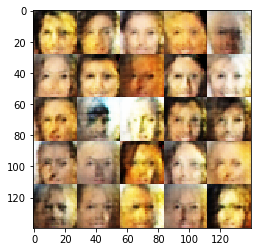

Epoch 1/1... Steps 3910/6332... Discriminator Loss: 1.0563... Generator Loss: 0.9387
Epoch 1/1... Steps 3920/6332... Discriminator Loss: 1.3247... Generator Loss: 0.6420
Epoch 1/1... Steps 3930/6332... Discriminator Loss: 1.1918... Generator Loss: 0.7440
Epoch 1/1... Steps 3940/6332... Discriminator Loss: 1.1112... Generator Loss: 0.6908
Epoch 1/1... Steps 3950/6332... Discriminator Loss: 1.3833... Generator Loss: 0.5085
Epoch 1/1... Steps 3960/6332... Discriminator Loss: 0.7311... Generator Loss: 1.2695
Epoch 1/1... Steps 3970/6332... Discriminator Loss: 0.7193... Generator Loss: 0.9722
Epoch 1/1... Steps 3980/6332... Discriminator Loss: 0.6822... Generator Loss: 1.4255
Epoch 1/1... Steps 3990/6332... Discriminator Loss: 0.7608... Generator Loss: 1.2467
Epoch 1/1... Steps 4000/6332... Discriminator Loss: 1.3113... Generator Loss: 0.7144


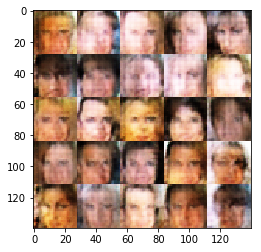

Epoch 1/1... Steps 4010/6332... Discriminator Loss: 1.0945... Generator Loss: 0.7772
Epoch 1/1... Steps 4020/6332... Discriminator Loss: 1.1583... Generator Loss: 0.8074
Epoch 1/1... Steps 4030/6332... Discriminator Loss: 0.6134... Generator Loss: 4.1510
Epoch 1/1... Steps 4040/6332... Discriminator Loss: 1.6480... Generator Loss: 0.9638
Epoch 1/1... Steps 4050/6332... Discriminator Loss: 0.8796... Generator Loss: 0.9694
Epoch 1/1... Steps 4060/6332... Discriminator Loss: 1.5292... Generator Loss: 0.3652
Epoch 1/1... Steps 4070/6332... Discriminator Loss: 1.6916... Generator Loss: 0.3750
Epoch 1/1... Steps 4080/6332... Discriminator Loss: 1.0890... Generator Loss: 0.6678
Epoch 1/1... Steps 4090/6332... Discriminator Loss: 1.4324... Generator Loss: 0.5468
Epoch 1/1... Steps 4100/6332... Discriminator Loss: 1.4728... Generator Loss: 0.5992


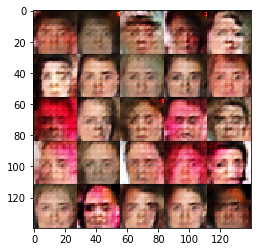

Epoch 1/1... Steps 4110/6332... Discriminator Loss: 1.1507... Generator Loss: 0.6949
Epoch 1/1... Steps 4120/6332... Discriminator Loss: 1.1824... Generator Loss: 1.0589
Epoch 1/1... Steps 4130/6332... Discriminator Loss: 1.4805... Generator Loss: 0.8681
Epoch 1/1... Steps 4140/6332... Discriminator Loss: 1.0750... Generator Loss: 0.9333
Epoch 1/1... Steps 4150/6332... Discriminator Loss: 1.4721... Generator Loss: 0.9131
Epoch 1/1... Steps 4160/6332... Discriminator Loss: 1.1867... Generator Loss: 0.6709
Epoch 1/1... Steps 4170/6332... Discriminator Loss: 0.9849... Generator Loss: 0.9906
Epoch 1/1... Steps 4180/6332... Discriminator Loss: 1.0672... Generator Loss: 1.3436
Epoch 1/1... Steps 4190/6332... Discriminator Loss: 1.4340... Generator Loss: 0.5068
Epoch 1/1... Steps 4200/6332... Discriminator Loss: 1.4829... Generator Loss: 0.3501


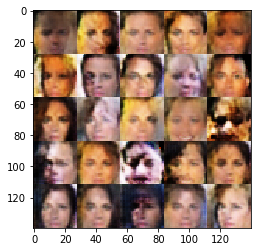

Epoch 1/1... Steps 4210/6332... Discriminator Loss: 0.6441... Generator Loss: 1.6746
Epoch 1/1... Steps 4220/6332... Discriminator Loss: 1.0683... Generator Loss: 0.9416
Epoch 1/1... Steps 4230/6332... Discriminator Loss: 0.5368... Generator Loss: 2.6146
Epoch 1/1... Steps 4240/6332... Discriminator Loss: 1.0397... Generator Loss: 0.6499
Epoch 1/1... Steps 4250/6332... Discriminator Loss: 0.9010... Generator Loss: 1.6457
Epoch 1/1... Steps 4260/6332... Discriminator Loss: 1.0509... Generator Loss: 1.4886
Epoch 1/1... Steps 4270/6332... Discriminator Loss: 1.3224... Generator Loss: 0.6254
Epoch 1/1... Steps 4280/6332... Discriminator Loss: 0.8657... Generator Loss: 1.2190
Epoch 1/1... Steps 4290/6332... Discriminator Loss: 1.5214... Generator Loss: 0.4012
Epoch 1/1... Steps 4300/6332... Discriminator Loss: 1.1987... Generator Loss: 0.7487


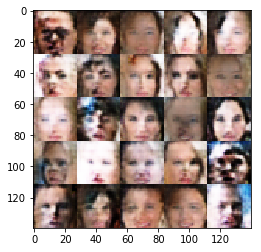

Epoch 1/1... Steps 4310/6332... Discriminator Loss: 1.1398... Generator Loss: 1.2211
Epoch 1/1... Steps 4320/6332... Discriminator Loss: 1.2978... Generator Loss: 1.1643
Epoch 1/1... Steps 4330/6332... Discriminator Loss: 1.3266... Generator Loss: 0.8783
Epoch 1/1... Steps 4340/6332... Discriminator Loss: 1.2098... Generator Loss: 1.1868
Epoch 1/1... Steps 4350/6332... Discriminator Loss: 0.8901... Generator Loss: 1.1811
Epoch 1/1... Steps 4360/6332... Discriminator Loss: 1.2612... Generator Loss: 0.7679
Epoch 1/1... Steps 4370/6332... Discriminator Loss: 1.2131... Generator Loss: 1.2367
Epoch 1/1... Steps 4380/6332... Discriminator Loss: 1.4640... Generator Loss: 0.5117
Epoch 1/1... Steps 4390/6332... Discriminator Loss: 2.2172... Generator Loss: 0.1603
Epoch 1/1... Steps 4400/6332... Discriminator Loss: 1.3377... Generator Loss: 0.5000


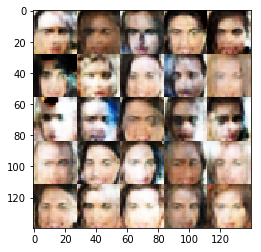

Epoch 1/1... Steps 4410/6332... Discriminator Loss: 1.1194... Generator Loss: 0.9964
Epoch 1/1... Steps 4420/6332... Discriminator Loss: 1.0123... Generator Loss: 1.0659
Epoch 1/1... Steps 4430/6332... Discriminator Loss: 0.8303... Generator Loss: 2.0020
Epoch 1/1... Steps 4440/6332... Discriminator Loss: 1.2686... Generator Loss: 0.5957
Epoch 1/1... Steps 4450/6332... Discriminator Loss: 1.5266... Generator Loss: 0.3338
Epoch 1/1... Steps 4460/6332... Discriminator Loss: 0.9357... Generator Loss: 0.8629
Epoch 1/1... Steps 4470/6332... Discriminator Loss: 1.0441... Generator Loss: 1.0976
Epoch 1/1... Steps 4480/6332... Discriminator Loss: 2.4067... Generator Loss: 0.1171
Epoch 1/1... Steps 4490/6332... Discriminator Loss: 1.2542... Generator Loss: 0.6136
Epoch 1/1... Steps 4500/6332... Discriminator Loss: 1.1250... Generator Loss: 1.0848


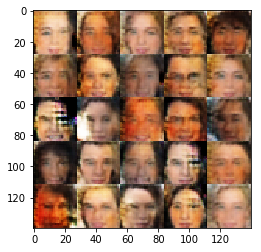

Epoch 1/1... Steps 4510/6332... Discriminator Loss: 1.0134... Generator Loss: 1.8547
Epoch 1/1... Steps 4520/6332... Discriminator Loss: 1.4635... Generator Loss: 0.8533
Epoch 1/1... Steps 4530/6332... Discriminator Loss: 1.4553... Generator Loss: 0.6890
Epoch 1/1... Steps 4540/6332... Discriminator Loss: 1.1210... Generator Loss: 1.0821
Epoch 1/1... Steps 4550/6332... Discriminator Loss: 1.1734... Generator Loss: 0.9342
Epoch 1/1... Steps 4560/6332... Discriminator Loss: 1.0841... Generator Loss: 0.9133
Epoch 1/1... Steps 4570/6332... Discriminator Loss: 0.8458... Generator Loss: 1.1107
Epoch 1/1... Steps 4580/6332... Discriminator Loss: 1.2070... Generator Loss: 0.9947
Epoch 1/1... Steps 4590/6332... Discriminator Loss: 0.9009... Generator Loss: 1.9985
Epoch 1/1... Steps 4600/6332... Discriminator Loss: 1.0923... Generator Loss: 0.7394


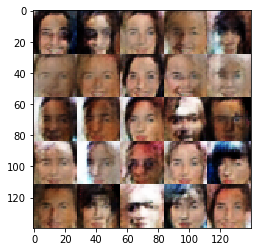

Epoch 1/1... Steps 4610/6332... Discriminator Loss: 1.3290... Generator Loss: 0.7659
Epoch 1/1... Steps 4620/6332... Discriminator Loss: 0.4358... Generator Loss: 5.5599
Epoch 1/1... Steps 4630/6332... Discriminator Loss: 1.1086... Generator Loss: 0.7132
Epoch 1/1... Steps 4640/6332... Discriminator Loss: 1.3158... Generator Loss: 0.5831
Epoch 1/1... Steps 4650/6332... Discriminator Loss: 1.4065... Generator Loss: 0.4970
Epoch 1/1... Steps 4660/6332... Discriminator Loss: 1.3339... Generator Loss: 0.6447
Epoch 1/1... Steps 4670/6332... Discriminator Loss: 0.8456... Generator Loss: 2.2339
Epoch 1/1... Steps 4680/6332... Discriminator Loss: 0.2007... Generator Loss: 4.0087
Epoch 1/1... Steps 4690/6332... Discriminator Loss: 1.3011... Generator Loss: 0.4299
Epoch 1/1... Steps 4700/6332... Discriminator Loss: 1.3869... Generator Loss: 0.7238


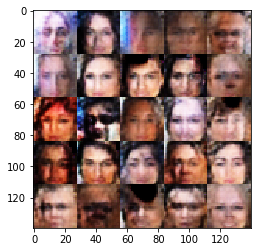

Epoch 1/1... Steps 4710/6332... Discriminator Loss: 1.2582... Generator Loss: 0.6692
Epoch 1/1... Steps 4720/6332... Discriminator Loss: 1.1490... Generator Loss: 0.7707
Epoch 1/1... Steps 4730/6332... Discriminator Loss: 0.8818... Generator Loss: 2.2486
Epoch 1/1... Steps 4740/6332... Discriminator Loss: 1.1258... Generator Loss: 0.7247
Epoch 1/1... Steps 4750/6332... Discriminator Loss: 1.4383... Generator Loss: 0.5207
Epoch 1/1... Steps 4760/6332... Discriminator Loss: 1.1162... Generator Loss: 0.6452
Epoch 1/1... Steps 4770/6332... Discriminator Loss: 1.3493... Generator Loss: 0.5595
Epoch 1/1... Steps 4780/6332... Discriminator Loss: 1.3223... Generator Loss: 0.7143
Epoch 1/1... Steps 4790/6332... Discriminator Loss: 1.2703... Generator Loss: 0.6917
Epoch 1/1... Steps 4800/6332... Discriminator Loss: 0.6907... Generator Loss: 1.8884


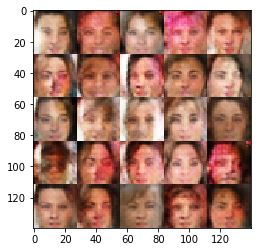

Epoch 1/1... Steps 4810/6332... Discriminator Loss: 1.3256... Generator Loss: 0.5067
Epoch 1/1... Steps 4820/6332... Discriminator Loss: 0.9964... Generator Loss: 1.2919
Epoch 1/1... Steps 4830/6332... Discriminator Loss: 0.8994... Generator Loss: 1.1863
Epoch 1/1... Steps 4840/6332... Discriminator Loss: 1.3855... Generator Loss: 0.5320
Epoch 1/1... Steps 4850/6332... Discriminator Loss: 1.3888... Generator Loss: 0.4488
Epoch 1/1... Steps 4860/6332... Discriminator Loss: 1.8301... Generator Loss: 0.2490
Epoch 1/1... Steps 4870/6332... Discriminator Loss: 1.2430... Generator Loss: 0.9165
Epoch 1/1... Steps 4880/6332... Discriminator Loss: 1.0193... Generator Loss: 1.0659
Epoch 1/1... Steps 4890/6332... Discriminator Loss: 1.8441... Generator Loss: 0.2759
Epoch 1/1... Steps 4900/6332... Discriminator Loss: 1.2415... Generator Loss: 0.7988


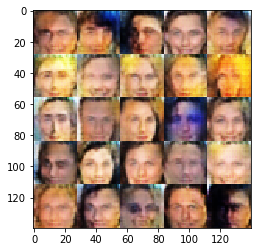

Epoch 1/1... Steps 4910/6332... Discriminator Loss: 1.4604... Generator Loss: 0.9644
Epoch 1/1... Steps 4920/6332... Discriminator Loss: 1.2058... Generator Loss: 0.7263
Epoch 1/1... Steps 4930/6332... Discriminator Loss: 1.2809... Generator Loss: 0.7207
Epoch 1/1... Steps 4940/6332... Discriminator Loss: 1.6989... Generator Loss: 0.2749
Epoch 1/1... Steps 4950/6332... Discriminator Loss: 1.0979... Generator Loss: 0.9596
Epoch 1/1... Steps 4960/6332... Discriminator Loss: 1.4599... Generator Loss: 0.6471
Epoch 1/1... Steps 4970/6332... Discriminator Loss: 1.4282... Generator Loss: 0.4507
Epoch 1/1... Steps 4980/6332... Discriminator Loss: 1.2634... Generator Loss: 0.7436
Epoch 1/1... Steps 4990/6332... Discriminator Loss: 1.5265... Generator Loss: 0.4257
Epoch 1/1... Steps 5000/6332... Discriminator Loss: 0.9463... Generator Loss: 0.9755


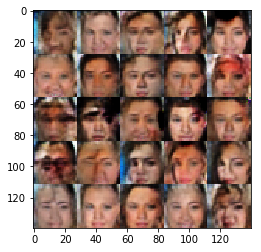

Epoch 1/1... Steps 5010/6332... Discriminator Loss: 1.1822... Generator Loss: 0.9021
Epoch 1/1... Steps 5020/6332... Discriminator Loss: 1.1090... Generator Loss: 0.8550
Epoch 1/1... Steps 5030/6332... Discriminator Loss: 0.8100... Generator Loss: 1.7756
Epoch 1/1... Steps 5040/6332... Discriminator Loss: 1.2211... Generator Loss: 0.9458
Epoch 1/1... Steps 5050/6332... Discriminator Loss: 1.5171... Generator Loss: 0.5945
Epoch 1/1... Steps 5060/6332... Discriminator Loss: 0.9842... Generator Loss: 1.3443
Epoch 1/1... Steps 5070/6332... Discriminator Loss: 0.1889... Generator Loss: 5.2213
Epoch 1/1... Steps 5080/6332... Discriminator Loss: 0.7357... Generator Loss: 1.6555
Epoch 1/1... Steps 5090/6332... Discriminator Loss: 0.9054... Generator Loss: 0.9787
Epoch 1/1... Steps 5100/6332... Discriminator Loss: 1.0008... Generator Loss: 1.0014


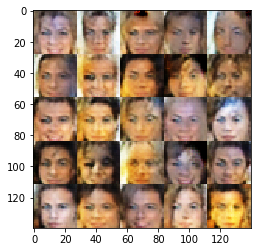

Epoch 1/1... Steps 5110/6332... Discriminator Loss: 1.1554... Generator Loss: 1.1773
Epoch 1/1... Steps 5120/6332... Discriminator Loss: 1.1105... Generator Loss: 0.8650
Epoch 1/1... Steps 5130/6332... Discriminator Loss: 1.5827... Generator Loss: 2.6573
Epoch 1/1... Steps 5140/6332... Discriminator Loss: 1.1531... Generator Loss: 0.7211
Epoch 1/1... Steps 5150/6332... Discriminator Loss: 1.2085... Generator Loss: 0.6957
Epoch 1/1... Steps 5160/6332... Discriminator Loss: 1.0545... Generator Loss: 1.1950
Epoch 1/1... Steps 5170/6332... Discriminator Loss: 1.4036... Generator Loss: 0.4113
Epoch 1/1... Steps 5180/6332... Discriminator Loss: 0.9932... Generator Loss: 0.9565
Epoch 1/1... Steps 5190/6332... Discriminator Loss: 1.6593... Generator Loss: 0.3532
Epoch 1/1... Steps 5200/6332... Discriminator Loss: 1.3455... Generator Loss: 0.5351


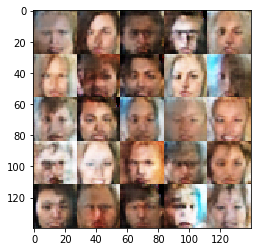

Epoch 1/1... Steps 5210/6332... Discriminator Loss: 1.1913... Generator Loss: 0.8174
Epoch 1/1... Steps 5220/6332... Discriminator Loss: 1.1753... Generator Loss: 1.0862
Epoch 1/1... Steps 5230/6332... Discriminator Loss: 1.7288... Generator Loss: 0.3050
Epoch 1/1... Steps 5240/6332... Discriminator Loss: 1.2664... Generator Loss: 0.6849
Epoch 1/1... Steps 5250/6332... Discriminator Loss: 1.1661... Generator Loss: 0.9187
Epoch 1/1... Steps 5260/6332... Discriminator Loss: 0.6567... Generator Loss: 1.2550
Epoch 1/1... Steps 5270/6332... Discriminator Loss: 1.1707... Generator Loss: 0.9549
Epoch 1/1... Steps 5280/6332... Discriminator Loss: 1.3249... Generator Loss: 0.6343
Epoch 1/1... Steps 5290/6332... Discriminator Loss: 1.0934... Generator Loss: 0.7843
Epoch 1/1... Steps 5300/6332... Discriminator Loss: 1.2656... Generator Loss: 0.8333


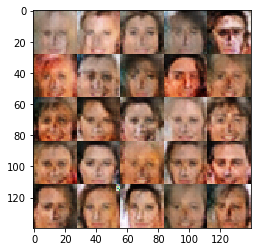

Epoch 1/1... Steps 5310/6332... Discriminator Loss: 0.9951... Generator Loss: 1.2132
Epoch 1/1... Steps 5320/6332... Discriminator Loss: 1.2423... Generator Loss: 0.7747
Epoch 1/1... Steps 5330/6332... Discriminator Loss: 0.6511... Generator Loss: 1.8366
Epoch 1/1... Steps 5340/6332... Discriminator Loss: 1.4090... Generator Loss: 0.5191
Epoch 1/1... Steps 5350/6332... Discriminator Loss: 1.1659... Generator Loss: 0.8254
Epoch 1/1... Steps 5360/6332... Discriminator Loss: 0.9294... Generator Loss: 0.9579
Epoch 1/1... Steps 5370/6332... Discriminator Loss: 1.1262... Generator Loss: 0.7205
Epoch 1/1... Steps 5380/6332... Discriminator Loss: 1.2555... Generator Loss: 0.5529
Epoch 1/1... Steps 5390/6332... Discriminator Loss: 1.1975... Generator Loss: 0.7708
Epoch 1/1... Steps 5400/6332... Discriminator Loss: 1.3988... Generator Loss: 0.7519


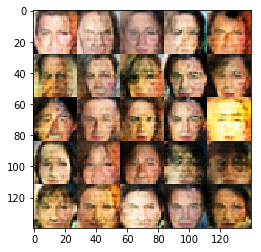

Epoch 1/1... Steps 5410/6332... Discriminator Loss: 1.4330... Generator Loss: 0.5104
Epoch 1/1... Steps 5420/6332... Discriminator Loss: 1.1325... Generator Loss: 0.9403
Epoch 1/1... Steps 5430/6332... Discriminator Loss: 1.5004... Generator Loss: 0.3332
Epoch 1/1... Steps 5440/6332... Discriminator Loss: 1.3210... Generator Loss: 0.7451
Epoch 1/1... Steps 5450/6332... Discriminator Loss: 1.5693... Generator Loss: 0.6501
Epoch 1/1... Steps 5460/6332... Discriminator Loss: 1.2082... Generator Loss: 0.7824
Epoch 1/1... Steps 5470/6332... Discriminator Loss: 1.4001... Generator Loss: 0.4764
Epoch 1/1... Steps 5480/6332... Discriminator Loss: 1.7598... Generator Loss: 1.4659
Epoch 1/1... Steps 5490/6332... Discriminator Loss: 1.1513... Generator Loss: 0.7258
Epoch 1/1... Steps 5500/6332... Discriminator Loss: 1.3788... Generator Loss: 0.7331


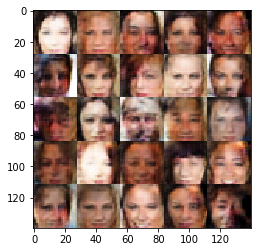

Epoch 1/1... Steps 5510/6332... Discriminator Loss: 1.1197... Generator Loss: 0.7743
Epoch 1/1... Steps 5520/6332... Discriminator Loss: 1.1940... Generator Loss: 0.7459
Epoch 1/1... Steps 5530/6332... Discriminator Loss: 0.9420... Generator Loss: 1.3353
Epoch 1/1... Steps 5540/6332... Discriminator Loss: 1.3112... Generator Loss: 0.7565
Epoch 1/1... Steps 5550/6332... Discriminator Loss: 0.7306... Generator Loss: 1.4626
Epoch 1/1... Steps 5560/6332... Discriminator Loss: 1.0282... Generator Loss: 0.8397
Epoch 1/1... Steps 5570/6332... Discriminator Loss: 1.1749... Generator Loss: 0.7374
Epoch 1/1... Steps 5580/6332... Discriminator Loss: 1.1696... Generator Loss: 0.9616
Epoch 1/1... Steps 5590/6332... Discriminator Loss: 1.2448... Generator Loss: 0.6952
Epoch 1/1... Steps 5600/6332... Discriminator Loss: 1.0720... Generator Loss: 0.9823


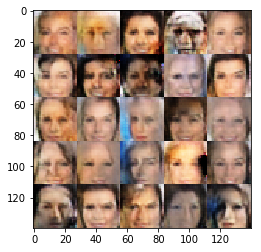

Epoch 1/1... Steps 5610/6332... Discriminator Loss: 1.2206... Generator Loss: 0.7705
Epoch 1/1... Steps 5620/6332... Discriminator Loss: 1.4592... Generator Loss: 0.4611
Epoch 1/1... Steps 5630/6332... Discriminator Loss: 0.8279... Generator Loss: 1.5674
Epoch 1/1... Steps 5640/6332... Discriminator Loss: 1.3101... Generator Loss: 0.7922
Epoch 1/1... Steps 5650/6332... Discriminator Loss: 1.2903... Generator Loss: 0.5847
Epoch 1/1... Steps 5660/6332... Discriminator Loss: 1.0952... Generator Loss: 1.6335
Epoch 1/1... Steps 5670/6332... Discriminator Loss: 1.1285... Generator Loss: 0.7519
Epoch 1/1... Steps 5680/6332... Discriminator Loss: 1.1441... Generator Loss: 0.7406
Epoch 1/1... Steps 5690/6332... Discriminator Loss: 1.4818... Generator Loss: 0.7949
Epoch 1/1... Steps 5700/6332... Discriminator Loss: 0.6879... Generator Loss: 2.5032


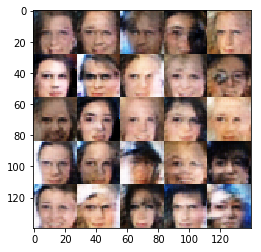

Epoch 1/1... Steps 5710/6332... Discriminator Loss: 1.2374... Generator Loss: 0.7044
Epoch 1/1... Steps 5720/6332... Discriminator Loss: 1.0418... Generator Loss: 2.1768
Epoch 1/1... Steps 5730/6332... Discriminator Loss: 0.9341... Generator Loss: 1.2575
Epoch 1/1... Steps 5740/6332... Discriminator Loss: 1.1811... Generator Loss: 0.6625
Epoch 1/1... Steps 5750/6332... Discriminator Loss: 1.2575... Generator Loss: 0.7370
Epoch 1/1... Steps 5760/6332... Discriminator Loss: 1.5052... Generator Loss: 0.7393
Epoch 1/1... Steps 5770/6332... Discriminator Loss: 1.6917... Generator Loss: 0.3916
Epoch 1/1... Steps 5780/6332... Discriminator Loss: 1.3805... Generator Loss: 0.6359
Epoch 1/1... Steps 5790/6332... Discriminator Loss: 1.1707... Generator Loss: 2.1622
Epoch 1/1... Steps 5800/6332... Discriminator Loss: 1.3828... Generator Loss: 0.6417


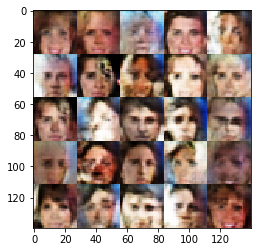

Epoch 1/1... Steps 5810/6332... Discriminator Loss: 1.2748... Generator Loss: 0.8145
Epoch 1/1... Steps 5820/6332... Discriminator Loss: 0.8288... Generator Loss: 0.8269
Epoch 1/1... Steps 5830/6332... Discriminator Loss: 1.1952... Generator Loss: 0.7239
Epoch 1/1... Steps 5840/6332... Discriminator Loss: 1.3067... Generator Loss: 0.9752
Epoch 1/1... Steps 5850/6332... Discriminator Loss: 1.2066... Generator Loss: 0.7461
Epoch 1/1... Steps 5860/6332... Discriminator Loss: 1.3668... Generator Loss: 0.5010
Epoch 1/1... Steps 5870/6332... Discriminator Loss: 1.1533... Generator Loss: 0.7228
Epoch 1/1... Steps 5880/6332... Discriminator Loss: 1.6349... Generator Loss: 0.3598
Epoch 1/1... Steps 5890/6332... Discriminator Loss: 0.8712... Generator Loss: 1.4792
Epoch 1/1... Steps 5900/6332... Discriminator Loss: 1.3857... Generator Loss: 0.4958


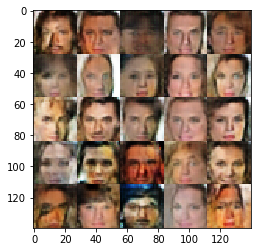

Epoch 1/1... Steps 5910/6332... Discriminator Loss: 1.2449... Generator Loss: 0.5586
Epoch 1/1... Steps 5920/6332... Discriminator Loss: 1.2325... Generator Loss: 0.7358
Epoch 1/1... Steps 5930/6332... Discriminator Loss: 1.5675... Generator Loss: 0.4066
Epoch 1/1... Steps 5940/6332... Discriminator Loss: 1.0621... Generator Loss: 0.7467
Epoch 1/1... Steps 5950/6332... Discriminator Loss: 1.6107... Generator Loss: 0.5245
Epoch 1/1... Steps 5960/6332... Discriminator Loss: 1.0976... Generator Loss: 0.8865
Epoch 1/1... Steps 5970/6332... Discriminator Loss: 1.6555... Generator Loss: 0.5991
Epoch 1/1... Steps 5980/6332... Discriminator Loss: 1.2878... Generator Loss: 0.6622
Epoch 1/1... Steps 5990/6332... Discriminator Loss: 1.1420... Generator Loss: 0.6264
Epoch 1/1... Steps 6000/6332... Discriminator Loss: 1.1348... Generator Loss: 1.3195


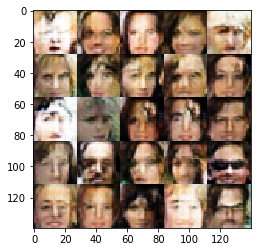

Epoch 1/1... Steps 6010/6332... Discriminator Loss: 1.0462... Generator Loss: 1.3816
Epoch 1/1... Steps 6020/6332... Discriminator Loss: 2.3608... Generator Loss: 0.1366
Epoch 1/1... Steps 6030/6332... Discriminator Loss: 1.3867... Generator Loss: 0.8940
Epoch 1/1... Steps 6040/6332... Discriminator Loss: 2.1538... Generator Loss: 0.1732
Epoch 1/1... Steps 6050/6332... Discriminator Loss: 1.4179... Generator Loss: 0.5741
Epoch 1/1... Steps 6060/6332... Discriminator Loss: 1.2420... Generator Loss: 0.6305
Epoch 1/1... Steps 6070/6332... Discriminator Loss: 1.3996... Generator Loss: 1.0559
Epoch 1/1... Steps 6080/6332... Discriminator Loss: 1.4562... Generator Loss: 0.4807
Epoch 1/1... Steps 6090/6332... Discriminator Loss: 0.8121... Generator Loss: 1.4926
Epoch 1/1... Steps 6100/6332... Discriminator Loss: 0.7935... Generator Loss: 4.0538


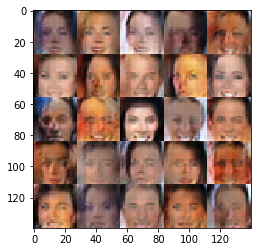

Epoch 1/1... Steps 6110/6332... Discriminator Loss: 1.0620... Generator Loss: 0.8883
Epoch 1/1... Steps 6120/6332... Discriminator Loss: 1.0535... Generator Loss: 1.1523
Epoch 1/1... Steps 6130/6332... Discriminator Loss: 1.9850... Generator Loss: 0.2293
Epoch 1/1... Steps 6140/6332... Discriminator Loss: 1.3640... Generator Loss: 0.7141
Epoch 1/1... Steps 6150/6332... Discriminator Loss: 1.2598... Generator Loss: 0.6519
Epoch 1/1... Steps 6160/6332... Discriminator Loss: 1.3872... Generator Loss: 0.5925
Epoch 1/1... Steps 6170/6332... Discriminator Loss: 1.4742... Generator Loss: 0.6216
Epoch 1/1... Steps 6180/6332... Discriminator Loss: 1.2509... Generator Loss: 0.8381
Epoch 1/1... Steps 6190/6332... Discriminator Loss: 1.0833... Generator Loss: 0.8409
Epoch 1/1... Steps 6200/6332... Discriminator Loss: 1.1739... Generator Loss: 0.7971


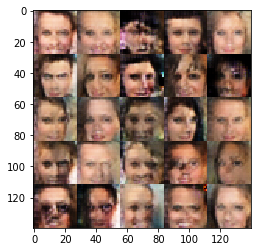

Epoch 1/1... Steps 6210/6332... Discriminator Loss: 1.2077... Generator Loss: 0.7697
Epoch 1/1... Steps 6220/6332... Discriminator Loss: 1.4710... Generator Loss: 0.7111
Epoch 1/1... Steps 6230/6332... Discriminator Loss: 1.4872... Generator Loss: 0.5135
Epoch 1/1... Steps 6240/6332... Discriminator Loss: 1.4063... Generator Loss: 0.5782
Epoch 1/1... Steps 6250/6332... Discriminator Loss: 1.3523... Generator Loss: 0.6703
Epoch 1/1... Steps 6260/6332... Discriminator Loss: 1.0540... Generator Loss: 2.0860
Epoch 1/1... Steps 6270/6332... Discriminator Loss: 1.2914... Generator Loss: 0.7083
Epoch 1/1... Steps 6280/6332... Discriminator Loss: 1.2789... Generator Loss: 0.7488
Epoch 1/1... Steps 6290/6332... Discriminator Loss: 1.1125... Generator Loss: 1.0191
Epoch 1/1... Steps 6300/6332... Discriminator Loss: 1.5475... Generator Loss: 0.3567


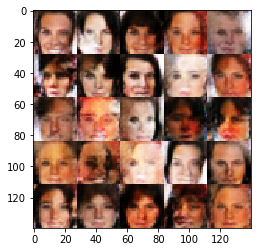

Epoch 1/1... Steps 6310/6332... Discriminator Loss: 1.4170... Generator Loss: 0.5847
Epoch 1/1... Steps 6320/6332... Discriminator Loss: 1.1351... Generator Loss: 0.9249
Epoch 1/1... Steps 6330/6332... Discriminator Loss: 1.0152... Generator Loss: 1.0357
Train procedure is completed!


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.